# Players ranking

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import datetime, time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pylab import hist, show
import scipy
import zipfile
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import seaborn as sn
from sklearn.metrics import silhouette_samples, silhouette_score


sys.setrecursionlimit(100000)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 200)

In [2]:
pwd

'/Users/stefanostselios/Desktop/nhl_roster_design-master'

### import play by play dataframe

In [3]:
da = pd.read_csv('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/pbp_merged.csv')
#da = pd.read_csv('/Users/kevinmongeon/Brock University/Steve Tselios - StephanosShare/out/pbp_merged.csv')
da = da.drop('Unnamed: 0', axis=1)
da = da.rename(columns={'TeamCode': 'EventTeamCode'})

- keep regular season games and events that happened in regulation and overtime (exclude shootouts). Drop rows that have 'NaN' in event number column and irrelevant data.

In [8]:
da = da[da['GameNumber'] <= 21230]
da = da[da['Period'] <= 4]
da = da[da['Period'] >= 1]
da = da[da['EventType']!='STOP']
da = da[da['EventType']!='EISTR']
da = da[da['EventType']!='EIEND']
da = da[da['PlayerName'] !='TEAM']
da = da[da['EventTeamCode'] != 'Neu']
da = da[da['EventTeamCode'] != 'Def']
da = da.dropna(subset=['EventNumber'])

In [9]:
da.shape

(314373, 44)

In [10]:
dlong = da.copy()
a = [col for col in dlong.columns if 'VPlayer' in col]
b = [col for col in dlong.columns if 'HPlayer' in col]
c = [col for col in dlong.columns if 'VPosition' in col]
d = [col for col in dlong.columns if 'HPosition' in col]
dlong = pd.lreshape(dlong, {'VPlayer' : a, 'HPlayer' : b, 'VPosition' : c, 'HPosition': d})

In [11]:
dlong.shape

(1817268, 24)

In [12]:
dlong['VPlayerName'] = dlong.apply(lambda x: x['PlayerName'] if (x['EventTeamCode'] == x['VTeamCode']) & (x['PlayerNumber'] == x['VPlayer']) else np.nan, axis=1)
dlong['VPlayerName'] = dlong.groupby(['Season','GameNumber', 'VTeamCode', 'VPlayer'])['VPlayerName'].apply(lambda x: x.ffill().bfill())

dlong['HPlayerName'] = dlong.apply(lambda x: x['PlayerName'] if (x['EventTeamCode'] == x['HTeamCode']) & (x['PlayerNumber'] == x['HPlayer']) else np.nan, axis=1)
dlong['HPlayerName'] = dlong.groupby(['Season','GameNumber', 'HTeamCode', 'HPlayer' ])['HPlayerName'].apply(lambda x: x.ffill().bfill())

## shots against

- calculate the shots against each player faced througout the duration of a season. Drop duplicates and eep one observation per player.

In [655]:
dsa = dlong.copy()
dsa['AdvantageType'] = dsa.groupby(['Season','GameNumber', 'Period'])['AdvantageType'].apply(lambda x: x.bfill())
#dsa.head()

In [656]:
dsa = dsa[['Season', 'GameNumber', 'Period', 'AdvantageType', 'EventNumber', 'EventTimeFromZero', 'EventType', 'EventDetail', 'EventTeamCode', 'PlayerNumber', 'PlayerName', 'VTeamCode', 'HTeamCode', 'VPlayer', 'VPlayerName', 'VPosition', 'HPlayer', 'HPlayerName', 'HPosition', 'Zone', 'ShotType', 'ShotResult']]
dsa = dsa.rename(columns={'EventTeamCode': 'EventTeam', 'PlayerNumber': 'PNumber', 'PlayerName': 'PN' , 'VPlayerName': 'VName', 'HPlayerName': 'HName'})

In [657]:
a = [col for col in dsa.columns if 'Code' in col]
b = [col for col in dsa.columns if 'Player' in col]
c = [col for col in dsa.columns if 'Name' in col]
d = [col for col in dsa.columns if 'Position' in col]
dsa = pd.lreshape(dsa, {'TeamCode' : a, 'PlayerNumber' : b, 'PlayerName':c, 'Position' : d})

In [658]:
dsa = dsa.rename(columns={'EventTeam': 'EventTeamCode', 'PNumber': 'EventPlayerNumber', 'PN': 'EventPlayerName'})

- create a shot against variable. If event team code is indiferrent to team code assign a value of 1. If not, assign a value of 0. **Goals are a result of a shot and therefore need to be added to a player's shot total**. Display total shots per player for a season.

In [659]:
dsa['ShotF'] = dsa.apply(lambda x: 1 if (x['EventType'] == 'SHOT') & (x['EventTeamCode'] == x['TeamCode']) else 1 if (x['EventType'] == 'GOAL') & (x['EventTeamCode'] == x['TeamCode']) else 0, axis=1)
dsa['ShotsF'] = dsa.groupby(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])['ShotF'].transform('sum')

dsa['ShotA'] = dsa.apply(lambda x: 1 if (x['EventType'] == 'SHOT') & (x['EventTeamCode'] != x['TeamCode']) else 1 if (x['EventType'] == 'GOAL') & (x['EventTeamCode'] != x['TeamCode']) else 0, axis=1)
dsa['ShotsA'] = dsa.groupby(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])['ShotA'].transform('sum')



In [660]:
dsa['DShots'] = dsa['ShotsF'] - dsa['ShotsA']

In [661]:
dsa = dsa [['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'ShotsF', 'ShotsA', 'DShots']]
dsa = dsa.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dsa['PlayerNumber'] = dsa['PlayerNumber'].astype(np.int)
dsa.head()

,Season,TeamCode,PlayerNumber,PlayerName,ShotsF,ShotsA,DShots
0,2010,MTL,11,GOMEZ,914,697,217
2,2010,MTL,14,PLEKANEC,879,825,54
9,2010,MTL,15,HALPERN,349,525,-176
13,2010,MTL,17,BOYD,33,62,-29
95,2010,MTL,94,PYATT,251,350,-99


In [651]:
dsa.shape

(1058, 6)

## plus/minus

In [19]:
dgfa = dlong.copy()
dgfa['AdvantageType'] = dgfa.groupby(['Season','GameNumber', 'Period'])['AdvantageType'].apply(lambda x: x.bfill())

In [20]:
dgfa = dgfa[['Season', 'GameNumber', 'Period', 'AdvantageType', 'EventNumber', 'EventTimeFromZero', 'EventType', 'EventDetail', 'EventTeamCode', 'PlayerNumber', 'PlayerName', 'VTeamCode', 'HTeamCode', 'VPlayer', 'VPlayerName', 'VPosition', 'HPlayer','HPlayerName', 'HPosition', 'Zone', 'ShotType', 'ShotResult']]
dgfa = dgfa.sort_values(['Season', 'GameNumber', 'EventNumber'], ascending=[True, True, True])
dgfa = dgfa.rename(columns={'EventTeamCode': 'EventTeam', 'PlayerNumber': 'PNumber', 'PlayerName': 'PN' , 'VPlayerName': 'VName', 'HPlayerName': 'HName'})

In [21]:
a = [col for col in dgfa.columns if 'Code' in col]
b = [col for col in dgfa.columns if 'Player' in col]
c = [col for col in dgfa.columns if 'Name' in col]
d = [col for col in dgfa.columns if 'Position' in col]
dgfa = pd.lreshape(dgfa, {'TeamCode' : a, 'PlayerNumber' : b, 'PlayerName': c, 'Position' : d})

In [22]:
dgfa = dgfa.rename(columns={'EventTeam': 'EventTeamCode', 'PNumber': 'EventPlayerNumber', 'PN': 'EventPlayerName'})

- create goals for and goals against variable. If event team code is the same as team code assign a value of 1 for goals for and a value of 0 for goals against. If event team code is different to team code,assign a value of 0 for golas for and a value of 1 for goals against. Display total goals for and against per player for a season.

In [23]:
dgfa['GoalF'] = dgfa.apply(lambda x: 1 if (x['EventType'] == 'GOAL') & (x['AdvantageType'] == 'EV') & (x['EventTeamCode'] == x['TeamCode']) else 0, axis=1)
dgfa['GoalA'] = dgfa.apply(lambda x: 1 if (x['EventType'] == 'GOAL') & (x['AdvantageType'] == 'EV') & (x['EventTeamCode'] != x['TeamCode']) else 0, axis=1)

In [24]:
dgfa['GoalsF'] = dgfa.groupby(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])['GoalF'].transform('sum')
dgfa['GoalsA'] = dgfa.groupby(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])['GoalA'].transform('sum')

In [25]:
dgfa = dgfa [['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'GoalsF', 'GoalsA']]
dgfa['Plus/Minus'] = dgfa['GoalsF'] - dgfa['GoalsA']
dgfa = dgfa.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dgfa['PlayerNumber'] = dgfa['PlayerNumber'].astype(np.int)
dgfa.head()

,Season,TeamCode,PlayerNumber,PlayerName,GoalsF,GoalsA,Plus/Minus
0,2010,MTL,11,GOMEZ,34,46,-12
1,2010,MTL,21,GIONTA,50,45,5
2,2010,MTL,57,POULIOT,36,34,2
3,2010,MTL,26,GORGES,21,24,-3
4,2010,MTL,75,GILL,38,49,-11


In [26]:
dgfa.dtypes

Season           int64
TeamCode        object
PlayerNumber     int64
PlayerName      object
GoalsF           int64
GoalsA           int64
Plus/Minus       int64
dtype: object

In [27]:
dgfa.shape

(1058, 7)

## player position

In [28]:
dz = dlong.copy()

- fill in NaN values for advantage type with the use of backfill.

In [29]:
dz['AdvantageType'] = dz.groupby(['Season','GameNumber', 'Period'])['AdvantageType'].apply(lambda x: x.bfill())

- apply lamda to determine the position of event player based on team code and player number. Group by season, game number, team code, player to backward and forward fill position. Drop observations that have incorrect team code.

In [30]:
dz = dz.sort_values(['Season', 'GameNumber', 'EventNumber'], ascending=[True, True, True])
dz['PlayerPosition'] = dz.apply(lambda x: x['HPosition'] if ((x['EventTeamCode'] == x['HTeamCode']) & (x['PlayerNumber'] == x['HPlayer'])) else x['VPosition'] if ((x['EventTeamCode'] == x['VTeamCode']) & (x['PlayerNumber'] == x['VPlayer'])) else np.nan, axis=1)
dz['PlayerPosition'] = dz.groupby(['Season', 'GameNumber', 'EventTeamCode', 'PlayerNumber', 'PlayerName'])['PlayerPosition'].apply(lambda x: x.ffill().bfill())

- display player position for the season. Group by season, team code, player.

In [31]:
dz['PlayerPosition'] = dz.groupby(['Season', 'EventTeamCode', 'PlayerNumber', 'PlayerName'])['PlayerPosition'].apply(lambda x: x.ffill().bfill())

In [32]:
dz2 = dz.copy()
dz2 = dz2[['Season', 'GameNumber', 'EventTeamCode', 'PlayerNumber', 'PlayerName', 'PlayerPosition']]
dz2 = dz2.drop_duplicates(['Season', 'GameNumber', 'EventTeamCode', 'PlayerNumber', 'PlayerName', 'PlayerPosition'])
dz2['Position'] = dz2.apply(lambda x: 'W' if x['PlayerPosition'] == 'L' else 'W' if x['PlayerPosition'] == 'R' else x['PlayerPosition'], axis=1)
dz2 = dz2[['Season', 'GameNumber', 'EventTeamCode', 'PlayerNumber', 'PlayerName', 'Position']]
dz2['PlayerNumber'] = dz2['PlayerNumber'].astype(np.int)
dz2.head()

,Season,GameNumber,EventTeamCode,PlayerNumber,PlayerName,Position
0,2010,20001,MTL,11,GOMEZ,C
1,2010,20001,TOR,37,BRENT,C
2,2010,20001,MTL,14,PLEKANEC,C
3,2010,20001,MTL,76,SUBBAN,D
4,2010,20001,TOR,35,GIGUERE,G


In [33]:
dz2.isnull().sum()

Season           0
GameNumber       0
EventTeamCode    0
PlayerNumber     0
PlayerName       0
Position         0
dtype: int64

## merge player position on play by play dataset

merge on season, game number, team code, player number and player name.

In [34]:
dn = pd.merge(dlong, dz2, on=['Season', 'GameNumber', 'EventTeamCode', 'PlayerNumber', 'PlayerName'], how='left')

- fill in NaN values for advantage type with the use of backfill.

In [35]:
dn['AdvantageType'] = dn.groupby(['Season','GameNumber', 'Period'])['AdvantageType'].apply(lambda x: x.bfill())

In [36]:
dn['Position'].value_counts()

C    716533
W    585301
D    507090
G      8344
Name: Position, dtype: int64

In [37]:
dn.shape

(1817268, 27)

## assists

- use event detail for goals information to identify the players that assisted on a given goal. Split event detail data into assist player 1 and assist player 2, to display primary and secondary assist. 

In [38]:
#number and name of assist player 1
dn['Assist'] = dn.EventDetail.str.split(':', expand = True)[1]
dn['Assist1'] = dn.Assist.str.split(';', expand = True)[0]
dn['A1a'] = dn.Assist1.str.split('#', expand = True)[1]
dn['A1b'] = dn.A1a.str.split('(', expand = True)[0]
dn['A1PlayerNumber'] = dn.A1b.str.split(' ', expand = True)[0]
dn['A1PlayerName'] = dn.A1b.str.split('\\d+', expand = True)[1]
dn['Assist1PlayerNumber'] = dn.A1PlayerNumber.str.split(' ', expand = True)[0]
dn['Assist1PlayerName'] = dn.A1PlayerName.str.split(' ', expand = True)[1]

#number and name of assist player 2 
dn['Assist2'] = dn.Assist.str.split(';', expand = True)[1]
dn['A2a'] = dn.Assist2.str.split('#', expand = True)[1]
dn['A2b'] = dn.A2a.str.split('(', expand = True)[0]
dn['A2PlayerNumber'] = dn.A2b.str.split(' ', expand = True)[0]
dn['A2PlayerName'] = dn.A2b.str.split('\\d+', expand = True)[1]
dn['Assist2PlayerNumber'] = dn.A2PlayerNumber.str.split(' ', expand = True)[0]
dn['Assist2PlayerName'] = dn.A2PlayerName.str.split(' ', expand = True)[1]

In [39]:
dn2 = dn.copy()
dn2 = dn2[['Season', 'GameDate', 'GameNumber', 'Period', 'Zone', 'AdvantageType', 'EventNumber', 'EventTimeFromZero', 'EventTimeFromTwenty', 'EventType', 'EventDetail', 'EventTeamCode', 'PlayerNumber', 'PlayerName', 'Position', 'VTeamCode', 'VPlayer', 'VPlayerName', 'VPosition', 'HTeamCode', 'HPlayer', 'HPlayerName', 'HPosition', 'Assist1PlayerNumber', 'Assist1PlayerName', 'Assist2PlayerNumber', 'Assist2PlayerName', 'ShotType', 'ShotResult', 'Length', 'PenaltyType' ]]

In [40]:
dn2.shape

(1817268, 31)

### create dataframes for all on-ice event types

#### goal dataframe (db)

In [41]:
db = dn2.copy()
db = db.rename(columns={'EventTeamCode': 'TeamCode' })
db = db.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])
#db = db[db['EventType'] == 'GOAL']

- create a goal variable. If event type is a goal assign a value of 1. If not, assign a value of 0. Display total goals per player for a season.

In [42]:
db['Goal'] = db.apply(lambda x: 1 if (x['EventType'] == 'GOAL') else 0, axis=1)
db = db.drop_duplicates(['Season', 'GameNumber', 'EventNumber', 'TeamCode', 'PlayerNumber', 'PlayerName'])
db['Goals'] = db.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Goal'].transform('sum')
db['Goals'] = db.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Goals'].apply(lambda x: x.ffill().bfill())

- keep one observation per player by game and drop duplicates. This purpose of this step is to calculate the quantity of games per player for a season. 

In [43]:
db = db.drop_duplicates(['Season', 'GameNumber', 'TeamCode', 'PlayerNumber', 'PlayerName'])
db['GP'] = db.groupby(['Season', 'TeamCode', 'PlayerNumber','PlayerName'])['GameNumber'].transform('count')
db = db.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])

In [44]:
db = db.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
db = db[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Position', 'GP', 'Goals']]
db['PlayerNumber'] = db['PlayerNumber'].astype(int)
db.head()

,Season,TeamCode,PlayerNumber,PlayerName,Position,GP,Goals
0,2010,MTL,11,GOMEZ,C,80,7
1,2010,TOR,37,BRENT,C,79,8
2,2010,MTL,14,PLEKANEC,C,77,22
3,2010,MTL,76,SUBBAN,D,77,14
4,2010,TOR,35,GIGUERE,G,17,0


In [45]:
db.isnull().sum()

Season          0
TeamCode        0
PlayerNumber    0
PlayerName      0
Position        0
GP              0
Goals           0
dtype: int64

In [46]:
db.shape

(1058, 7)

#### assist dataframe (dc)

- This dataset contains only event type that were goals.

In [47]:
dc = dn2.copy()
dc = dc.rename(columns={'Assist1PlayerNumber': 'AssistPlayerNumber1', 'Assist1PlayerName': 'AssistPlayerName1', 'Assist2PlayerNumber': 'AssistPlayerNumber2', 'Assist2PlayerName': 'AssistPlayerName2', 'PlayerName': 'EventPlayerName', 'PlayerNumber': 'EventPlayerNumber' })
dc = dc.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])

In [48]:
dc = dc[['Season', 'GameDate', 'GameNumber', 'EventNumber', 'EventType', 'Period', 'EventTeamCode', 'EventPlayerNumber', 'EventPlayerName', 'AssistPlayerNumber1', 'AssistPlayerName1', 'AssistPlayerNumber2', 'AssistPlayerName2']]
#dc.head()

In [49]:
dc['AssistTeamCode1'] = dc.apply(lambda x: x['EventTeamCode'] if (x['EventType'] == 'GOAL') else np.nan, axis=1)
dc['AssistTeamCode2'] = dc.apply(lambda x: x['EventTeamCode'] if (x['EventType'] == 'GOAL') else np.nan, axis=1)
dc['AA1'] = dc.apply(lambda x: 1 if (x['EventType'] == 'GOAL') else 0, axis=1)
dc['AA2'] = dc.apply(lambda x: 1 if (x['EventType'] == 'GOAL') else 0, axis=1)
dc.head()

,Season,GameDate,GameNumber,EventNumber,EventType,Period,EventTeamCode,EventPlayerNumber,EventPlayerName,AssistPlayerNumber1,AssistPlayerName1,AssistPlayerNumber2,AssistPlayerName2,AssistTeamCode1,AssistTeamCode2,AA1,AA2
0,2010,2010-10-07,20001,1,FAC,1,MTL,11.0,GOMEZ,None,None,None,None,NaN,NaN,0,0
314373,2010,2010-10-07,20001,1,FAC,1,MTL,11.0,GOMEZ,None,None,None,None,NaN,NaN,0,0
628644,2010,2010-10-07,20001,1,FAC,1,MTL,11.0,GOMEZ,None,None,None,None,NaN,NaN,0,0
942837,2010,2010-10-07,20001,1,FAC,1,MTL,11.0,GOMEZ,None,None,None,None,NaN,NaN,0,0
1256963,2010,2010-10-07,20001,1,FAC,1,MTL,11.0,GOMEZ,None,None,None,None,NaN,NaN,0,0


- reshape data from wide to long based on assist variables to display both primary and secondary assists in one column.

In [50]:
a = [col for col in dc.columns if 'AssistPlayerNumber' in col]
b = [col for col in dc.columns if 'AssistPlayerName' in col]
c = [col for col in dc.columns if 'AssistTeamCode' in col]
d = [col for col in dc.columns if 'AA' in col]
dc = pd.lreshape(dc, {'PlayerNumber' : a, 'PlayerName' : b, 'TeamCode': c, 'Assist': d})
dc = dc.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])
dc.head()

,EventNumber,EventPlayerName,EventPlayerNumber,EventTeamCode,EventType,GameDate,GameNumber,Period,Season,PlayerNumber,PlayerName,TeamCode,Assist
0,35,BRENT,37.0,TOR,GOAL,2010-10-07,20001,1,2010,3,PHANEUF,TOR,1
1,35,BRENT,37.0,TOR,GOAL,2010-10-07,20001,1,2010,3,PHANEUF,TOR,1
2,35,BRENT,37.0,TOR,GOAL,2010-10-07,20001,1,2010,3,PHANEUF,TOR,1
3,35,BRENT,37.0,TOR,GOAL,2010-10-07,20001,1,2010,3,PHANEUF,TOR,1
4,35,BRENT,37.0,TOR,GOAL,2010-10-07,20001,1,2010,3,PHANEUF,TOR,1


In [51]:
dc = dc.drop_duplicates(['Season', 'GameNumber', 'EventNumber', 'TeamCode', 'PlayerNumber', 'PlayerName'])

In [52]:
dc.shape

(11524, 13)

- create assist variables. Assign a value of 1 if an event was a goal; 0 otherwise. Calculate the total assists each player resgistered for a season.

In [53]:
dc['Assists'] = dc.groupby(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])['Assist'].transform('sum')
dc['Assists'] = dc.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Assists'].apply(lambda x: x.ffill().bfill())

- keep one observation per player for the season and drop duplicates.

In [54]:
dc['PlayerNumber'] = dc['PlayerNumber'].astype(np.int)
dc = dc.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dc = dc[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Assists']]
dc.head()

,Season,TeamCode,PlayerNumber,PlayerName,Assists
0,2010,TOR,3,PHANEUF,22
6,2010,TOR,42,BOZAK,17
35643,2010,TOR,8,KOMISAREK,9
12,2010,TOR,41,KULEMIN,27
35649,2010,TOR,84,GRABOVSKI,29


In [55]:
dc.isnull().sum()

Season          0
TeamCode        0
PlayerNumber    0
PlayerName      0
Assists         0
dtype: int64

In [56]:
dc.shape

(851, 5)

#### shot dataframe (ds)

In [57]:
ds = dn2.copy()
ds = ds.rename(columns={'EventTeamCode': 'TeamCode' })
ds = ds.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])

- create a shot variable. If event type is a shot assign a value of 1. If not, assign a value of 0. **Goals are a result of a shot and therefore need to be added to a player's shot total**. Display total shots per player for a season.

In [58]:
ds['Shot'] = ds.apply(lambda x: 1 if (x['EventType'] == 'SHOT') else 1 if (x['EventType'] == 'GOAL') else 0, axis=1)
ds = ds.drop_duplicates(['Season', 'GameNumber', 'EventNumber', 'TeamCode', 'PlayerNumber', 'PlayerName'])
ds['Shots'] = ds.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Shot'].transform('sum')
ds['Shots'] = ds.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Shots'].apply(lambda x: x.ffill().bfill())

- drop duplicates to keep one observation per player for the season.


In [59]:
ds = ds.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
ds = ds[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Shots']]
ds['PlayerNumber'] = ds['PlayerNumber'].astype(np.int)
ds.head()

,Season,TeamCode,PlayerNumber,PlayerName,Shots
0,2010,MTL,11,GOMEZ,156
1,2010,TOR,37,BRENT,60
2,2010,MTL,14,PLEKANEC,227
3,2010,MTL,76,SUBBAN,197
4,2010,TOR,35,GIGUERE,0


In [60]:
ds.isnull().sum()

Season          0
TeamCode        0
PlayerNumber    0
PlayerName      0
Shots           0
dtype: int64

In [61]:
ds.shape

(1058, 5)

#### block dataframe (dl)

In [62]:
dl = dn2.copy()
dl = dl.rename(columns={'EventTeamCode': 'TeamCode' })
dl = dl.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])

- create a block variable. If event type is a block assign a value of 1. If not, assign a value of 0. Display total blocks per player for a season.

In [63]:
dl['Block'] = dl.apply(lambda x: 1 if (x['EventType'] == 'BLOCK') else 0, axis=1)
dl = dl.drop_duplicates(['Season', 'GameNumber', 'EventNumber', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dl['Blocks'] = dl.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Block'].transform('sum')
dl['Blocks'] = dl.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Blocks'].apply(lambda x: x.ffill().bfill())

- drop duplicates to keep one observation per player for the season.

In [64]:
dl = dl.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dl = dl[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Blocks']]
dl['PlayerNumber'] = dl['PlayerNumber'].astype(np.int)
dl.head()

,Season,TeamCode,PlayerNumber,PlayerName,Blocks
0,2010,MTL,11,GOMEZ,24
1,2010,TOR,37,BRENT,58
2,2010,MTL,14,PLEKANEC,45
3,2010,MTL,76,SUBBAN,106
4,2010,TOR,35,GIGUERE,0


In [65]:
dl.isnull().sum()

Season          0
TeamCode        0
PlayerNumber    0
PlayerName      0
Blocks          0
dtype: int64

In [66]:
dl.shape

(1058, 5)

#### miss dataframe (dm)

In [67]:
dm = dn2.copy()
dm = dm.rename(columns={'EventTeamCode': 'TeamCode' })
dm = dm.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])

- create a miss variable. If event type is a miss assign a value of 1. If not, assign a value of 0. Display total misses per player for a season.

In [68]:
dm['Miss'] = dm.apply(lambda x: 1 if (x['EventType'] == 'MISS') else 0, axis=1)
dm = dm.drop_duplicates(['Season', 'GameNumber', 'EventNumber', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dm['Misses'] = dm.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Miss'].transform('sum')
dm['Misses'] = dm.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Misses'].apply(lambda x: x.ffill().bfill())

- drop duplicates to keep one observation per player for the season.

In [69]:
dm = dm.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dm = dm[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Misses']]
dm['PlayerNumber'] = dm['PlayerNumber'].astype(np.int)
dm.head()

,Season,TeamCode,PlayerNumber,PlayerName,Misses
0,2010,MTL,11,GOMEZ,57
1,2010,TOR,37,BRENT,28
2,2010,MTL,14,PLEKANEC,79
3,2010,MTL,76,SUBBAN,78
4,2010,TOR,35,GIGUERE,0


In [70]:
dm.isnull().sum()

Season          0
TeamCode        0
PlayerNumber    0
PlayerName      0
Misses          0
dtype: int64

In [71]:
dm.shape

(1058, 5)

####  hit dataframe (dh)

In [72]:
dh = dn2.copy()
dh = dh.rename(columns={'EventTeamCode': 'TeamCode' })
dh = dh.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])

- create a hit variable. If event type is a hit assign a value of 1. If not, assign a value of 0. Display total hits per player for a season.

In [73]:
dh['Hit'] = dh.apply(lambda x: 1 if (x['EventType'] == 'HIT') else 0, axis=1)
dh = dh.drop_duplicates(['Season', 'GameNumber', 'EventNumber', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dh['Hits'] = dh.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Hit'].transform('sum')
dh['Hits'] = dh.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Hits'].apply(lambda x: x.ffill().bfill())

- drop duplicates to keep one observation per player for the season.

In [74]:
dh = dh.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dh = dh[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Hits']]
dh['PlayerNumber'] = dh['PlayerNumber'].astype(np.int)
dh.head()

,Season,TeamCode,PlayerNumber,PlayerName,Hits
0,2010,MTL,11,GOMEZ,32
1,2010,TOR,37,BRENT,104
2,2010,MTL,14,PLEKANEC,53
3,2010,MTL,76,SUBBAN,110
4,2010,TOR,35,GIGUERE,0


In [75]:
dh.isnull().sum()

Season          0
TeamCode        0
PlayerNumber    0
PlayerName      0
Hits            0
dtype: int64

In [76]:
dh.shape

(1058, 5)

#### penalty dataframe (dp)

In [77]:
dp = dn2.copy()
dp = dp.rename(columns={'EventTeamCode': 'TeamCode' })
dp = dp.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])
dp = dp.drop_duplicates(['Season', 'GameNumber', 'EventNumber', 'TeamCode', 'PlayerNumber', 'PlayerName'])

- Use 'EventDetail' to locate the duration of each penalty. Drop duplicates by game, event, team, player so there is one observation per event. Group by team, player to calcute the sum of penalty minutes for the season.

In [78]:
dp['Penalty'] = dp.EventDetail.str.split('(\\d+)', expand = True)[3]
dp['Penalty'] = dp['Penalty'].convert_objects(convert_numeric=True)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [79]:
dp['P'] = dp.apply(lambda x: x['Penalty'] if (x['EventType'] == 'PENL') else 0, axis=1)
dp['Penalties'] = dp.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['P'].transform('sum')
dp['Penalties'] = dp.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Penalties'].apply(lambda x: x.ffill().bfill())

- drop duplicates to keep one observation per player for the season.

In [80]:
dp = dp.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dp = dp[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Penalties']]
dp['PlayerNumber'] = dp['PlayerNumber'].astype(np.int)
dp['Penalties'] = dp['Penalties'].astype(np.int)
dp.head()

,Season,TeamCode,PlayerNumber,PlayerName,Penalties
0,2010,MTL,11,GOMEZ,48
1,2010,TOR,37,BRENT,31
2,2010,MTL,14,PLEKANEC,60
3,2010,MTL,76,SUBBAN,124
4,2010,TOR,35,GIGUERE,4


In [81]:
dp.isnull().sum()

Season          0
TeamCode        0
PlayerNumber    0
PlayerName      0
Penalties       0
dtype: int64

In [82]:
dp.shape

(1058, 5)

####  faceoff dataframe (df)

In [83]:
df = dn2.copy()
df = df.rename(columns={'EventTeamCode': 'TeamCode' })
df = df.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])

- create a faceoff variable. If event type is a faceoff assign a value of 1. If not, assign a value of 0. Display total faceoffs per player for a season.

In [84]:
df['Faceoff'] = df.apply(lambda x: 1 if (x['EventType'] == 'FAC') else 0, axis=1)
df = df.drop_duplicates(['Season', 'GameNumber', 'EventNumber', 'TeamCode', 'PlayerNumber', 'PlayerName'])
df['Faceoffs'] = df.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Faceoff'].transform('sum')
df['Faceoffs'] = df.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Faceoffs'].apply(lambda x: x.ffill().bfill())

- drop duplicates to keep one observation per player for the season.

In [85]:
df = df.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
df = df[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Faceoffs']]
df['PlayerNumber'] = df['PlayerNumber'].astype(np.int)
df.head()

,Season,TeamCode,PlayerNumber,PlayerName,Faceoffs
0,2010,MTL,11,GOMEZ,575
1,2010,TOR,37,BRENT,410
2,2010,MTL,14,PLEKANEC,785
3,2010,MTL,76,SUBBAN,0
4,2010,TOR,35,GIGUERE,0


In [86]:
df.isnull().sum()

Season          0
TeamCode        0
PlayerNumber    0
PlayerName      0
Faceoffs        0
dtype: int64

In [87]:
df.shape

(1058, 5)

####  giveaway dataframe (di)

In [88]:
di = dn2.copy()
di = di.rename(columns={'EventTeamCode': 'TeamCode' })
di = di.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])

- create a giveaway variable. If event type is a giveaway assign a value of 1. If not, assign a value of 0. Display total giveaways per player for a season.

In [89]:
di['Giveaway'] = di.apply(lambda x: 1 if (x['EventType'] == 'GIVE') else 0, axis=1)
di = di.drop_duplicates(['Season', 'GameNumber', 'EventNumber', 'TeamCode', 'PlayerNumber', 'PlayerName'])
di['Giveaways'] = di.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Giveaway'].transform('sum')
di['Giveaways '] = di.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Giveaways'].apply(lambda x: x.ffill().bfill())

- drop duplicates to keep one observation per player for the season.

In [90]:
di = di.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
di = di[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Giveaways']]
di['PlayerNumber'] = di['PlayerNumber'].astype(np.int)
di.head()

,Season,TeamCode,PlayerNumber,PlayerName,Giveaways
0,2010,MTL,11,GOMEZ,28
1,2010,TOR,37,BRENT,20
2,2010,MTL,14,PLEKANEC,37
3,2010,MTL,76,SUBBAN,56
4,2010,TOR,35,GIGUERE,33


In [91]:
di.isnull().sum()

Season          0
TeamCode        0
PlayerNumber    0
PlayerName      0
Giveaways       0
dtype: int64

In [92]:
di.shape

(1058, 5)

####  takeaway dataframe (dt)

In [93]:
dt = dn2.copy()
dt = dt.rename(columns={'EventTeamCode': 'TeamCode' })
dt = dt.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])

- create a takeaway variable. If event type is a takeaway  assign a value of 1. If not, assign a value of 0. Display total takeaways per player for a season.

In [94]:
dt['Takeaway'] = dt.apply(lambda x: 1 if (x['EventType'] == 'TAKE') else 0, axis=1)
dt = dt.drop_duplicates(['Season', 'GameNumber', 'EventNumber', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dt['Takeaways'] = dt.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Takeaway'].transform('sum')
dt['Takeaways'] = dt.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Takeaways'].apply(lambda x: x.ffill().bfill())

- drop duplicates to keep one observation per player for the season.

In [95]:
dt = dt.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dt = dt[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Takeaways']]
dt['PlayerNumber'] = dt['PlayerNumber'].astype(np.int)
dt.head()

,Season,TeamCode,PlayerNumber,PlayerName,Takeaways
0,2010,MTL,11,GOMEZ,56
1,2010,TOR,37,BRENT,23
2,2010,MTL,14,PLEKANEC,43
3,2010,MTL,76,SUBBAN,37
4,2010,TOR,35,GIGUERE,0


In [96]:
dt.isnull().sum()

Season          0
TeamCode        0
PlayerNumber    0
PlayerName      0
Takeaways       0
dtype: int64

In [97]:
dt.shape

(1058, 5)

## merge dataframes 

- goals and assists together to calcualte points per player.

In [98]:
dd = pd.merge(db, dc, on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'], how='left')
dd.head()

,Season,TeamCode,PlayerNumber,PlayerName,Position,GP,Goals,Assists
0,2010,MTL,11,GOMEZ,C,80,7,31.0
1,2010,TOR,37,BRENT,C,79,8,12.0
2,2010,MTL,14,PLEKANEC,C,77,22,35.0
3,2010,MTL,76,SUBBAN,D,77,14,24.0
4,2010,TOR,35,GIGUERE,G,17,0,NaN


In [99]:
dd.shape

(1058, 8)

In [100]:
dd.isnull().sum()

Season            0
TeamCode          0
PlayerNumber      0
PlayerName        0
Position          0
GP                0
Goals             0
Assists         220
dtype: int64

- fill zero for players that had no assists. 
- drop duplicates by team, player number and player name. 
- calculate points and plus/minus per player for the season.

In [101]:
dd['Assists'] = dd['Assists'].fillna(0)
dd['Assists'] = dd['Assists'].astype(np.int)
dd['Points'] = dd['Goals'] + dd['Assists']
dd.head()

,Season,TeamCode,PlayerNumber,PlayerName,Position,GP,Goals,Assists,Points
0,2010,MTL,11,GOMEZ,C,80,7,31,38
1,2010,TOR,37,BRENT,C,79,8,12,20
2,2010,MTL,14,PLEKANEC,C,77,22,35,57
3,2010,MTL,76,SUBBAN,D,77,14,24,38
4,2010,TOR,35,GIGUERE,G,17,0,0,0


In [102]:
dd.shape

(1058, 9)

- merge all data frames on dd.

In [662]:
dk = pd.merge(dd, dgfa,on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName']).merge(ds,on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName']).merge(dsa,on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName']).merge(dl,on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName']).merge(dh,on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName']).merge(dp,on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName']).merge(dt,on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName']).merge(di,on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName']).merge(dm,on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName']).merge(df,on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dk.head()

,Season,TeamCode,PlayerNumber,PlayerName,Position,GP,Goals,Assists,Points,GoalsF,GoalsA,Plus/Minus,Shots,ShotsF,ShotsA,DShots,Blocks,Hits,Penalties,Takeaways,Giveaways,Misses,Faceoffs
0,2010,MTL,11,GOMEZ,C,80,7,31,38,34,46,-12,156,914,697,217,24,32,48,56,28,57,575
1,2010,TOR,37,BRENT,C,79,8,12,20,20,25,-5,60,329,515,-186,58,104,31,23,20,28,410
2,2010,MTL,14,PLEKANEC,C,77,22,35,57,52,42,10,227,879,825,54,45,53,60,43,37,79,785
3,2010,MTL,76,SUBBAN,D,77,14,24,38,49,55,-6,197,986,816,170,106,110,124,37,56,78,0
4,2010,TOR,35,GIGUERE,G,17,0,0,0,34,34,0,0,390,444,-54,0,0,4,0,33,0,0


In [663]:
dk.shape

(1058, 23)

check if there are any 'NaN' values in all columns. Fill 'NaN' values with zero.

In [664]:
dk.isnull().sum()

Season          0
TeamCode        0
PlayerNumber    0
PlayerName      0
Position        0
GP              0
Goals           0
Assists         0
Points          0
GoalsF          0
GoalsA          0
Plus/Minus      0
Shots           0
ShotsF          0
ShotsA          0
DShots          0
Blocks          0
Hits            0
Penalties       0
Takeaways       0
Giveaways       0
Misses          0
Faceoffs        0
dtype: int64

### import player shift data and keep only regular season games.

In [1759]:
dv = pd.read_csv('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/data/t_player_shift_o.csv')
#dv = pd.read_csv('/Users/kevinmongeon/Brock University/Steve Tselios - StephanosShare/data/t_t_player_shift_o.csv')

In [1760]:
dv.columns

Index(['season', 'gamenumber', 'teamcode', 'playernumber', 'period',
       'starttime', 'endtime'],
      dtype='object')

- keep only regular seasong games. Display the duration of each shift per player. Calculate the time on ice by player for each game and transform seconds into minutes. Drop duplicates by season, gamenumber, teamcode and playernumber.

In [1788]:
dv = dv.rename(columns={'season': 'Season', 'gamenumber': 'GameNumber', 'teamcode': 'TeamCode', 'period': 'Period', 'playernumber': 'PlayerNumber', 'starttime': 'StartTime', 'endtime': 'EndTime' })
dv = dv[dv['GameNumber'] <= 21230]
dv['Shift'] = dv['EndTime'] - dv['StartTime']
dv['Seconds'] = dv.groupby(['Season', 'GameNumber', 'TeamCode', 'PlayerNumber'])['Shift'].transform('sum')
dv['Minutes'] = dv['Seconds']/60
dv['Minutes'] = dv['Minutes'].round(2)
dv.head()

,Season,GameNumber,TeamCode,PlayerNumber,Period,StartTime,EndTime,Shift,Seconds,Minutes
0,2010,20001,MTL,6,1,43,95,52,1222,20.37
1,2010,20001,MTL,6,1,186,247,61,1222,20.37
2,2010,20001,MTL,6,1,312,343,31,1222,20.37
3,2010,20001,MTL,6,1,461,513,52,1222,20.37
4,2010,20001,MTL,6,1,608,649,41,1222,20.37


In [1789]:
dv.shape

(958577, 10)

In [1790]:
dq = dlong.copy()
dq = dq[['Season', 'GameNumber', 'Period', 'EventTeamCode', 'PlayerNumber', 'PlayerName']]
dq = dq.rename(columns={'EventTeamCode': 'TeamCode' })
dq['PlayerNumber'] = dq['PlayerNumber'].astype(np.int)
dq.head()

,Season,GameNumber,Period,TeamCode,PlayerNumber,PlayerName
0,2010,20001,1,MTL,11,GOMEZ
1,2010,20001,1,TOR,37,BRENT
2,2010,20001,1,MTL,14,PLEKANEC
3,2010,20001,1,MTL,76,SUBBAN
4,2010,20001,1,TOR,35,GIGUERE


In [1791]:
dq.shape

(1817268, 6)

In [1794]:
dx = pd.merge(dq, dv, on=['Season', 'GameNumber', 'Period', 'TeamCode', 'PlayerNumber'], how='left')
dx = dx[['Season', 'GameNumber', 'Period', 'TeamCode', 'PlayerNumber', 'PlayerName', 'StartTime', 'EndTime', 'Shift', 'Seconds', 'Minutes']]
dx.head()

,Season,GameNumber,Period,TeamCode,PlayerNumber,PlayerName,StartTime,EndTime,Shift,Seconds,Minutes
0,2010,20001,1,MTL,11,GOMEZ,0.0,35.0,35.0,1121.0,18.68
1,2010,20001,1,MTL,11,GOMEZ,186.0,224.0,38.0,1121.0,18.68
2,2010,20001,1,MTL,11,GOMEZ,267.0,312.0,45.0,1121.0,18.68
3,2010,20001,1,MTL,11,GOMEZ,465.0,513.0,48.0,1121.0,18.68
4,2010,20001,1,MTL,11,GOMEZ,659.0,689.0,30.0,1121.0,18.68


In [1795]:
dx.isnull().sum()

Season            0
GameNumber        0
Period            0
TeamCode          0
PlayerNumber      0
PlayerName        0
StartTime       293
EndTime         293
Shift           293
Seconds         293
Minutes         293
dtype: int64

In [1796]:
dx = dx.drop_duplicates(['Season', 'GameNumber', 'TeamCode', 'PlayerNumber'])
dx['GP'] = dx.groupby(['Season', 'TeamCode', 'PlayerNumber','PlayerName'])['GameNumber'].transform('count')
dx.head()

,Season,GameNumber,Period,TeamCode,PlayerNumber,PlayerName,StartTime,EndTime,Shift,Seconds,Minutes,GP
0,2010,20001,1,MTL,11,GOMEZ,0.0,35.0,35.0,1121.0,18.68,80
7,2010,20001,1,TOR,37,BRENT,0.0,32.0,32.0,968.0,16.13,79
13,2010,20001,1,MTL,14,PLEKANEC,35.0,95.0,60.0,1129.0,18.82,77
21,2010,20001,1,MTL,76,SUBBAN,43.0,106.0,63.0,1342.0,22.37,77
30,2010,20001,1,TOR,35,GIGUERE,0.0,835.0,835.0,3529.0,58.82,17


In [1799]:
dx['TSeconds'] = dx.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Seconds'].transform('sum')
dx['TOI'] = dx['TSeconds'] / 60
dx['TOI'] = dx['TOI'].round(2)
dx['ATOI'] = dx['TOI']/dx['GP']
dx['ATOI'] = dx['ATOI'].round(2)
dx = dx.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dx.head()

,Season,GameNumber,Period,TeamCode,PlayerNumber,PlayerName,StartTime,EndTime,Shift,Seconds,Minutes,GP,TSeconds,TOI,ATOI
0,2010,20001,1,MTL,11,GOMEZ,0.0,35.0,35.0,1121.0,18.68,80,89106.0,1485.10,18.56
7,2010,20001,1,TOR,37,BRENT,0.0,32.0,32.0,968.0,16.13,79,55227.0,920.45,11.65
13,2010,20001,1,MTL,14,PLEKANEC,35.0,95.0,60.0,1129.0,18.82,77,93550.0,1559.17,20.25
21,2010,20001,1,MTL,76,SUBBAN,43.0,106.0,63.0,1342.0,22.37,77,102882.0,1714.70,22.27
30,2010,20001,1,TOR,35,GIGUERE,0.0,835.0,835.0,3529.0,58.82,17,58358.0,972.63,57.21


In [1800]:
dx.shape

(1058, 15)

## stats per player 

In [1807]:
dw = pd.merge(dk, dx, on=['Season', 'GP', 'TeamCode', 'PlayerNumber', 'PlayerName'], how='left')
dw.head()

,Season,TeamCode,PlayerNumber,PlayerName,Position,GP,Goals,Assists,Points,GoalsF,GoalsA,Plus/Minus,Shots,ShotsF,ShotsA,DShots,Blocks,Hits,Penalties,Takeaways,Giveaways,Misses,Faceoffs,GameNumber,Period,StartTime,EndTime,Shift,Seconds,Minutes,TSeconds,TOI,ATOI
0,2010,MTL,11,GOMEZ,C,80,7,31,38,34,46,-12,156,914,697,217,24,32,48,56,28,57,575,20001,1,0.0,35.0,35.0,1121.0,18.68,89106.0,1485.10,18.56
1,2010,TOR,37,BRENT,C,79,8,12,20,20,25,-5,60,329,515,-186,58,104,31,23,20,28,410,20001,1,0.0,32.0,32.0,968.0,16.13,55227.0,920.45,11.65
2,2010,MTL,14,PLEKANEC,C,77,22,35,57,52,42,10,227,879,825,54,45,53,60,43,37,79,785,20001,1,35.0,95.0,60.0,1129.0,18.82,93550.0,1559.17,20.25
3,2010,MTL,76,SUBBAN,D,77,14,24,38,49,55,-6,197,986,816,170,106,110,124,37,56,78,0,20001,1,43.0,106.0,63.0,1342.0,22.37,102882.0,1714.70,22.27
4,2010,TOR,35,GIGUERE,G,17,0,0,0,34,34,0,0,390,444,-54,0,0,4,0,33,0,0,20001,1,0.0,835.0,835.0,3529.0,58.82,58358.0,972.63,57.21


- change Byfuglien position from winger to defense.

In [1808]:
dw['Position'] = dw.apply(lambda x: 'D' if x['PlayerName'] == 'BYFUGLIEN' else x['Position'], axis=1)

In [1809]:
dw.to_csv('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/stats_per_player_nhl_positions.csv', index='False', sep=',')
#dw = pd.read_csv('/Users/kevinmongeon/Brock University/Steve Tselios - StephanosShare/out/clusters/stats_per_player_nhl_positions.csv', index='False', sep=',')

In [1810]:
dw.shape

(1058, 33)

## histogram of games played

- create a new data frame without goaltenders. 
- The purpose of plotting a histogram, is to view the distribution of games played by all skaters. Players that have played a substainial amount of few games are excluded by the data set. Since the data spiked significantly at 9 games, players that played 9 games and less are removed. 

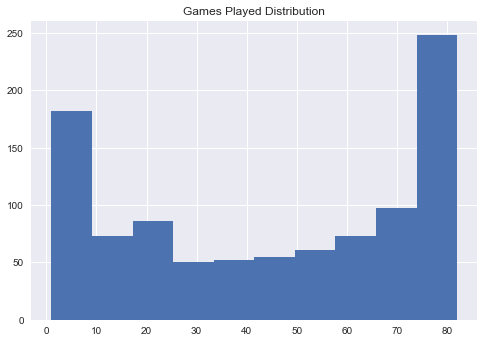

In [1811]:
dws = dw[dw['Position'] != 'G']
x1 = dws.GP 
plt.title('Games Played Distribution')
plt.hist(x1)
plt.show()

In [1812]:
dws = dws.sort_values(['ATOI', 'TOI'], ascending=[False, False])
dws.head()

,Season,TeamCode,PlayerNumber,PlayerName,Position,GP,Goals,Assists,Points,GoalsF,GoalsA,Plus/Minus,Shots,ShotsF,ShotsA,DShots,Blocks,Hits,Penalties,Takeaways,Giveaways,Misses,Faceoffs,GameNumber,Period,StartTime,EndTime,Shift,Seconds,Minutes,TSeconds,TOI,ATOI
120,2010,CHI,2,KEITH,D,82,7,38,45,77,81,-4,173,1216,1072,144,149,45,22,56,83,101,0,20004,1,0.0,40.0,40.0,2019.0,33.65,131929.0,2198.82,26.81
211,2010,SJ,22,BOYLE,D,76,9,41,50,65,62,3,199,1238,914,324,139,55,67,34,51,90,0,20006,1,0.0,49.0,49.0,1679.0,27.98,119652.0,1994.20,26.24
171,2010,CGY,4,BOUWMEESTER,D,81,4,20,24,64,69,-5,121,1005,1090,-85,134,72,44,23,57,54,0,20005,1,39.0,101.0,62.0,1408.0,23.47,125140.0,2085.67,25.75
539,2010,LA,8,DOUGHTY,D,76,9,31,40,73,58,15,137,1028,805,223,101,137,68,22,77,75,0,20023,1,0.0,30.0,30.0,1759.0,29.32,116923.0,1948.72,25.64
962,2010,DAL,33,GOLIGOSKI,D,23,5,10,15,19,20,-1,61,335,258,77,32,24,12,6,25,26,0,20900,1,0.0,47.0,47.0,1414.0,23.57,35377.0,589.62,25.64


In [1813]:
dws.to_csv('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/stats_skaters_nhl_positions.csv', index='False', sep=',')
#dws.to_csv('/Users/kevinmongeon/Brock University/Steve Tselios - StephanosShare/out/clusters/stats_skaters_nhl_positions.csv', index='False', sep=',')

## total stats for forwards

- display stats for forwards by excluding defensemen

In [2412]:
dcw = dws[(dws['Position'] != 'D')]
dcw = dcw.sort_values(['ATOI', 'Points'], ascending=[False, False])
dcw.head()

,Season,TeamCode,PlayerNumber,PlayerName,Position,GP,Goals,Assists,Points,GoalsF,GoalsA,Plus/Minus,Shots,ShotsF,ShotsA,DShots,Blocks,Hits,Penalties,Takeaways,Giveaways,Misses,Faceoffs,GameNumber,Period,StartTime,EndTime,Shift,Seconds,Minutes,TSeconds,TOI,ATOI
259,2010,ANA,10,PERRY,W,82,50,47,97,78,70,8,290,999,888,111,41,64,104,55,54,102,9,20009,1,56.0,96.0,40.0,894.0,14.90,109781.0,1829.68,22.31
252,2010,NJ,17,KOVALCHUK,W,81,31,29,60,51,71,-20,244,974,739,235,12,28,28,43,104,104,9,20007,3,57.0,115.0,58.0,1407.0,23.45,108206.0,1803.43,22.26
75,2010,CAR,12,STAAL,C,81,33,43,76,68,74,-6,296,1059,941,118,31,81,72,64,44,133,839,20003,1,54.0,84.0,30.0,1154.0,19.23,106990.0,1783.17,22.01
37,2010,PIT,87,CROSBY,C,41,32,34,66,50,29,21,161,594,376,218,23,31,29,15,29,58,546,20002,1,0.0,26.0,26.0,1482.0,24.70,53917.0,898.62,21.92
276,2010,ANA,15,GETZLAF,C,67,19,57,76,71,54,17,117,837,651,186,57,189,35,35,81,65,542,20009,1,56.0,96.0,40.0,1269.0,21.15,87861.0,1464.35,21.86


In [2413]:
dcw.shape

(635, 33)

- forwards that have been traded need to be evaluated for their season performance.

In [2414]:
f= dcw.copy()
f['Count'] = f.apply(lambda x: 1 if (x['PlayerName'] == x['PlayerName']) else 0, axis=1)
f['Player'] = f.groupby('PlayerName')['Count'].transform('sum')
f = f[f['Player'] > 1]
f = f.sort_values(['Player', 'PlayerName'], ascending=[False, True])
f.shape

(171, 35)

- exclude players that have the same name but are different individuals

In [2415]:
f = f[(f['PlayerName'] != 'JONES') & (f['PlayerName'] != 'BROWN') & (f['PlayerName'] != 'DUPUIS') & (f['PlayerName'] != 'GIONTA') & (f['PlayerName'] != 'HALL') & (f['PlayerName'] != 'JOKINEN') & (f['PlayerName'] != 'MITCHELL') & (f['PlayerName'] != 'OREILLY') & (f['PlayerName'] != 'PALMIERI') & (f['PlayerName'] != 'PORTER')& (f['PlayerName'] != 'PYATT') & (f['PlayerName'] != 'RICHARDS') & (f['PlayerName'] != 'SEDIN') & (f['PlayerName'] != 'STAAL') & (f['PlayerName'] != 'THORNTON') & (f['PlayerName'] != 'WHITE') & (f['PlayerName'] != 'WILSON') & (f['PlayerName'] != 'WILLIAMS') & (f['PlayerName'] != 'KANE') & (f['PlayerName'] != 'KOIVU') & (f['PlayerName'] != 'KOSTITSYN') & (f['PlayerName'] != 'GILLIES') & (f['PlayerName'] != 'GORDON') & (f['PlayerName'] != 'HOLMSTROM') & (f['PlayerName'] != 'JOHNSON') & (f['PlayerName'] != 'KING') & (f['PlayerName'] != 'GIROUX') & (f['PlayerName'] != 'KENNEDY') & (f['PlayerName'] != 'MCMILLAN') & (f['PlayerName'] != 'POULIOT') & (f['PlayerName'] != 'SESTITO') & (f['PlayerName'] != 'SMITH') & (f['PlayerName'] != 'WELLWOOD') & (f['PlayerName'] != 'MUELLER') & (f['PlayerName'] != 'MORIN')] 
f.shape

(99, 35)

- compute season stats for traded players.

In [2416]:
# total games played for the season
f['TGP'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else 0 if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['GP'], axis=1)
f['TGP'] = f.groupby('PlayerName')['TGP'].transform('sum')
f['TGP'] = f.apply(lambda x: x['GP'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['GP'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['GP'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['GP'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['GP'] if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['TGP'], axis=1)

# total points for the season
f['TPoints'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else 0 if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['Points'], axis=1)
f['TPoints'] = f.groupby('PlayerName')['TPoints'].transform('sum')
f['TPoints'] = f.apply(lambda x: x['Points'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Points'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Points'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Points'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Points'] if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['TPoints'], axis=1)

# total goals for the season
f['TGoals'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else 0 if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['Goals'], axis=1)
f['TGoals'] = f.groupby('PlayerName')['TGoals'].transform('sum')
f['TGoals'] = f.apply(lambda x: x['Goals'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Goals'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Goals'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Goals'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Goals'] if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR')else x['TGoals'], axis=1)

# total assists for the season
f['TAssists'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else 0 if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['Assists'], axis=1)
f['TAssists'] = f.groupby('PlayerName')['TAssists'].transform('sum')
f['TAssists'] = f.apply(lambda x: x['Assists'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Assists'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Assists'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Assists'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Assists'] if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['TAssists'], axis=1)

# total goals on ice for the season
f['TGoalsF'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else 0 if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['GoalsF'], axis=1)
f['TGoalsF'] = f.groupby('PlayerName')['TGoalsF'].transform('sum')
f['TGoalsF'] = f.apply(lambda x: x['GoalsF'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['GoalsF'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['GoalsF'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['GoalsF'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['GoalsF'] if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['TGoalsF'], axis=1)

# total goals on ice against for the season
f['TGoalsA'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else 0 if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['GoalsA'], axis=1)
f['TGoalsA'] = f.groupby('PlayerName')['TGoals'].transform('sum')
f['TGoalsA'] = f.apply(lambda x: x['GoalsA'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['GoalsA'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['GoalsA'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['GoalsA'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['GoalsA'] if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['TGoalsA'], axis=1)

# total plus/minus for the season
f['TPlus/Minus'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else 0 if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['Plus/Minus'], axis=1)
f['TPlus/Minus'] = f.groupby('PlayerName')['TPlus/Minus'].transform('sum')
f['TPlus/Minus'] = f.apply(lambda x: x['Plus/Minus'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Plus/Minus'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Plus/Minus'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Plus/Minus'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Plus/Minus'] if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['TPlus/Minus'], axis=1)

# total shots for the season
f['TShots'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else 0 if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['Shots'], axis=1)
f['TShots'] = f.groupby('PlayerName')['TShots'].transform('sum')
f['TShots'] = f.apply(lambda x: x['Shots'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Shots'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Shots'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Shots'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Shots'] if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['TShots'], axis=1)

# total shots against for the season
f['TShotsF'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else 0 if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['ShotsF'], axis=1)
f['TShotsF'] = f.groupby('PlayerName')['TShotsF'].transform('sum')
f['TShotsF'] = f.apply(lambda x: x['ShotsF'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['ShotsA'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['ShotsA'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['ShotsA'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['ShotsA'] if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['TShotsF'], axis=1)

# total shots against for the season
f['TShotsA'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else 0 if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['ShotsA'], axis=1)
f['TShotsA'] = f.groupby('PlayerName')['TShotsA'].transform('sum')
f['TShotsA'] = f.apply(lambda x: x['ShotsA'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['ShotsA'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['ShotsA'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['ShotsA'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['ShotsA'] if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['TShotsA'], axis=1)

# total shots differential for the season
f['TShotsD'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else 0 if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['DShots'], axis=1)
f['TShotsD'] = f.groupby('PlayerName')['TShotsD'].transform('sum')
f['TShotsD'] = f.apply(lambda x: x['ShotsA'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['ShotsA'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['ShotsA'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['ShotsA'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['ShotsA'] if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['TShotsD'], axis=1)

# total blocks for the season
f['TBlocks'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else 0 if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['Blocks'], axis=1)
f['TBlocks'] = f.groupby('PlayerName')['TBlocks'].transform('sum')
f['TBlocks'] = f.apply(lambda x: x['Blocks'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Blocks'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Blocks'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Blocks'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Blocks'] if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['TBlocks'], axis=1)

# total hits for the season
f['THits'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else 0 if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['Hits'], axis=1)
f['THits'] = f.groupby('PlayerName')['THits'].transform('sum')
f['THits'] = f.apply(lambda x: x['Hits'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Hits'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Hits'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Hits'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Hits'] if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['THits'], axis=1)

# total faceoffs for the season
f['TFaceoffs'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else 0 if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['Faceoffs'], axis=1)
f['TFaceoffs'] = f.groupby('PlayerName')['TFaceoffs'].transform('sum')
f['TFaceoffs'] = f.apply(lambda x: x['Faceoffs'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Faceoffs'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Faceoffs'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Faceoffs'] if (x['PlayerName'] == 'WINCHESTER') & (x['TFaceoffs'] == 'OTT') else x['Faceoffs'] if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['TFaceoffs'], axis=1)

# total miss shots for the season
f['TMisses'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else 0 if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['Misses'], axis=1)
f['TMisses'] = f.groupby('PlayerName')['TMisses'].transform('sum')
f['TMisses'] = f.apply(lambda x: x['Misses'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Misses'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Misses'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Misses'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Misses'] if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['TMisses'], axis=1)

# total penalties for the season
f['TPenalties'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else 0 if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['Penalties'], axis=1)
f['TPenalties'] = f.groupby('PlayerName')['TPenalties'].transform('sum')
f['TPenalties'] = f.apply(lambda x: x['Penalties'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Penalties'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Penalties'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Penalties'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Penalties'] if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['TPenalties'], axis=1)

# total giveaways for the season
f['TGiveaways'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else 0 if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['Giveaways'], axis=1)
f['TGiveaways'] = f.groupby('PlayerName')['TGiveaways'].transform('sum')
f['TGiveaways'] = f.apply(lambda x: x['Giveaways'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Giveaways'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Giveaways'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Giveaways'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Giveaways'] if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['TGiveaways'], axis=1)

# total takeaways for the season
f['TTakeaways'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else 0 if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['Takeaways'], axis=1)
f['TTakeaways'] = f.groupby('PlayerName')['TTakeaways'].transform('sum')
f['TTakeaways'] = f.apply(lambda x: x['Takeaways'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Takeaways'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Takeaways'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Takeaways'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Takeaways'] if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['TTakeaways'], axis=1)

# time on ice for the season
f['TTOI'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else 0 if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['TOI'], axis=1)
f['TTOI'] = f.groupby('PlayerName')['TTOI'].transform('sum')
f['TTOI'] = f.apply(lambda x: x['TOI'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['TOI'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['TOI'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['TOI'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['TOI'] if (x['PlayerName'] == 'SUTTER') & (x['TeamCode'] == 'CAR') else x['TTOI'], axis=1)

merge traded players onto forwards dataframe. 

In [2417]:
dfs = pd.merge(dcw, f, on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Position', 'GP', 'Goals', 'Assists', 'Points', 'GoalsF', 'GoalsA', 'Plus/Minus', 'Shots', 'ShotsF', 'ShotsA', 'DShots', 'Blocks', 'Hits', 'Faceoffs', 'Misses', 'Penalties', 'Giveaways', 'Takeaways', 'TOI', 'ATOI'], how='left')
dfs.shape

(635, 62)

- season stats per player.

In [2418]:
dfs['TGP'] = dfs.apply(lambda x: x['GP'] if pd.isnull(x['TGP']) else x['TGP'], axis=1)

dfs['TPoints'] = dfs.apply(lambda x: x['Points'] if pd.isnull(x['TPoints']) else x['TPoints'], axis=1)
dfs['TGoals'] = dfs.apply(lambda x: x['Goals'] if pd.isnull(x['TGoals']) else x['TGoals'], axis=1)
dfs['TAssists'] = dfs.apply(lambda x: x['Assists'] if pd.isnull(x['TAssists']) else x['TAssists'], axis=1)

dfs['TGoalsF'] = dfs.apply(lambda x: x['GoalsF'] if pd.isnull(x['TGoalsF']) else x['TGoalsF'], axis=1)
dfs['TGoalsA'] = dfs.apply(lambda x: x['GoalsA'] if pd.isnull(x['TGoalsA']) else x['TGoalsA'], axis=1)
dfs['TPlus/Minus'] = dfs.apply(lambda x: x['Plus/Minus'] if pd.isnull(x['TPlus/Minus']) else x['TPlus/Minus'], axis=1)

dfs['TShots'] = dfs.apply(lambda x: x['Shots'] if pd.isnull(x['TShots']) else x['TShots'], axis=1)
dfs['TShotsF'] = dfs.apply(lambda x: x['ShotsF'] if pd.isnull(x['TShotsF']) else x['TShotsF'], axis=1)
dfs['TShotsA'] = dfs.apply(lambda x: x['ShotsA'] if pd.isnull(x['TShotsA']) else x['TShotsA'], axis=1)
dfs['TShotsD'] = dfs.apply(lambda x: x['DShots'] if pd.isnull(x['TShotsD']) else x['TShotsD'], axis=1)

dfs['TMisses'] = dfs.apply(lambda x: x['Misses'] if pd.isnull(x['TMisses']) else x['TMisses'], axis=1)
dfs['TBlocks'] = dfs.apply(lambda x: x['Blocks'] if pd.isnull(x['TBlocks']) else x['TBlocks'], axis=1)
dfs['THits'] = dfs.apply(lambda x: x['Hits'] if pd.isnull(x['THits']) else x['THits'], axis=1)

dfs['TFaceoffs'] = dfs.apply(lambda x: x['Faceoffs'] if pd.isnull(x['TFaceoffs']) else x['TFaceoffs'], axis=1)
dfs['TPenalties'] = dfs.apply(lambda x: x['Penalties'] if pd.isnull(x['TPenalties']) else x['TPenalties'], axis=1)

dfs['TGiveaways'] = dfs.apply(lambda x: x['Giveaways'] if pd.isnull(x['TGiveaways']) else x['TGiveaways'], axis=1)
dfs['TTakeaways'] = dfs.apply(lambda x: x['Takeaways'] if pd.isnull(x['TTakeaways']) else x['TTakeaways'], axis=1)

dfs['TTOI'] = dfs.apply(lambda x: x['TOI'] if pd.isnull(x['TTOI']) else x['TTOI'], axis=1)

- season stats per time on ice. All players are evaluated on the same scale.

In [2419]:
dfs['TOIPoints'] = dfs['TPoints']/dfs['TTOI']
dfs['TOIGoals'] = dfs['TGoals']/dfs['TTOI']
dfs['TOIAssists'] = dfs['TAssists']/dfs['TTOI']

dfs['TOIGoalsF'] = dfs['TGoalsF']/dfs['TTOI']
dfs['TOIGoalsA'] = dfs['TGoalsA']/dfs['TTOI']
dfs['TOIPlus/Minus'] = dfs['TPlus/Minus']/dfs['TTOI']

dfs['TOIShots'] = dfs['TShots']/dfs['TTOI']
dfs['TOIShotsF'] = dfs['TShotsF']/dfs['TTOI']
dfs['TOIShotsA'] = dfs['TShotsA']/dfs['TTOI']
dfs['TOIShotsD'] = dfs['TShotsD']/dfs['TTOI']

dfs['TOIMisses'] = dfs['TMisses']/dfs['TTOI']
dfs['TOIBlocks'] = dfs['TBlocks']/dfs['TTOI']
dfs['TOIHits'] = dfs['THits']/dfs['TTOI']

dfs['TOIFaceoffs'] = dfs['TFaceoffs']/dfs['TTOI']
dfs['TOIPenalties'] = dfs['TPenalties']/dfs['TTOI']

dfs['TOIGiveaways'] = dfs['TGiveaways']/dfs['TGP']
dfs['TOITakeaways'] = dfs['TTakeaways']/dfs['TTOI']


dfs['TATOI'] = dfs['TTOI']/dfs['TGP']
dfs['TATOI'] = dfs['TATOI'].round(2)

In [2420]:
dfs.columns

Index(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Position', 'GP',
       'Goals', 'Assists', 'Points', 'GoalsF', 'GoalsA', 'Plus/Minus', 'Shots',
       'ShotsF', 'ShotsA', 'DShots', 'Blocks', 'Hits', 'Penalties',
       'Takeaways', 'Giveaways', 'Misses', 'Faceoffs', 'GameNumber_x',
       'Period_x', 'StartTime_x', 'EndTime_x', 'Shift_x', 'Seconds_x',
       'Minutes_x', 'TSeconds_x', 'TOI', 'ATOI', 'GameNumber_y', 'Period_y',
       'StartTime_y', 'EndTime_y', 'Shift_y', 'Seconds_y', 'Minutes_y',
       'TSeconds_y', 'Count', 'Player', 'TGP', 'TPoints', 'TGoals', 'TAssists',
       'TGoalsF', 'TGoalsA', 'TPlus/Minus', 'TShots', 'TShotsF', 'TShotsA',
       'TShotsD', 'TBlocks', 'THits', 'TFaceoffs', 'TMisses', 'TPenalties',
       'TGiveaways', 'TTakeaways', 'TTOI', 'TOIPoints', 'TOIGoals',
       'TOIAssists', 'TOIGoalsF', 'TOIGoalsA', 'TOIPlus/Minus', 'TOIShots',
       'TOIShotsF', 'TOIShotsA', 'TOIShotsD', 'TOIMisses', 'TOIBlocks',
       'TOIHits', 'TOIFaceoffs', 'TO

In [2421]:
dfs = dfs[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Position', 'TGP', 'TPoints', 'TGoals', 'TAssists', 'TGoalsF', 'TGoalsA', 'TPlus/Minus', 'TShots', 'TShotsF', 'TShotsA', 'TShotsD', 'TBlocks', 'THits', 'TMisses', 'TPenalties', 'TGiveaways', 'TTakeaways', 'TTOI', 'TOIPoints', 'TOIGoals', 'TOIAssists', 'TOIGoalsF', 'TOIGoalsA', 'TOIPlus/Minus', 'TOIShots', 'TOIShotsF', 'TOIShotsA', 'TOIShotsD', 'TOIMisses', 'TOIBlocks', 'TOIHits', 'TOIFaceoffs', 'TOIPenalties', 'TOIGiveaways', 'TOITakeaways', 'TATOI']]
dfs.shape

(635, 41)

### forwards time on ice distribution 

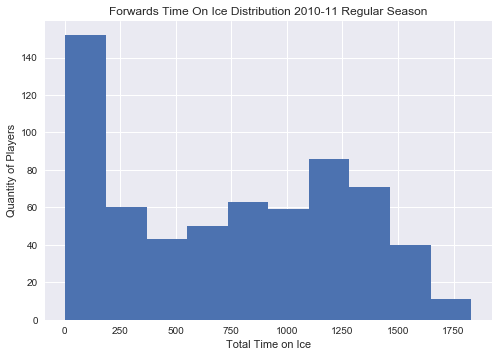

In [2422]:
x2 = dfs.TTOI 
plt.title('Forwards Time On Ice Distribution 2010-11 Regular Season')
plt.xlabel('Total Time on Ice')
plt.ylabel('Quantity of Players')
#plt.xlim(186,188)
plt.hist(x2)
plt.show()
plt.savefig('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/forwards_toi.pdf')

- Players that have played less than 189 minutes for the season are excluded from the cluster analysis. Since game level data is being used, those players will be ranked as 4th line players.

In [2423]:
low = dfs.copy()
low = low[low['TTOI'] < 189]
low.shape

(152, 41)

In [2424]:
dfs = dfs[dfs['TTOI'] > 189]

In [2425]:
dfs.shape

(483, 41)

In [1850]:
#dfs.to_csv('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/total_stats_forwards_nhl_positions.csv', index='False', sep=',')
#dfs.to_csv('/Users/kevinmongeon/Brock University/Steve Tselios - StephanosShare/out/clusters/total_stats_forwards_nhl_positions.csv', index='False', sep=',')

## cluster for centers

In [2354]:
dc = dfs.copy()
dc = dc[dc['Position'] == 'C']
dc.shape

(204, 41)

### standardization

- It is important to standardize the data so that we can effectively compare player performance. 
- Scale on-ice events per minute for each player relative to the league's season minimum and maximumn performance. All on-ice events per minute will have values between 0 and 1. 
- This technique makes sure that no particular event is being overweighted.

In [2355]:
#scaler = MinMaxScaler()
scaler = StandardScaler()
c = dc[['TOIPoints', 'TOIGoals', 'TOIAssists', 'TOIPlus/Minus', 'TOIShotsD', 'TOIBlocks', 'TOIHits', 'TOIPenalties']]
c_scaled = scaler.fit_transform(c)

### dendrogram

- Dendogram shows the distance between any two observations in a dataset. The vertical axis determines the distance. The longer the axis, the larger the distance.
- The clustermap feature in seaborn provides the dendogram. It also displays the distance between observations as well as the features.

In [2405]:
cmap = sn.cubehelix_palette(as_cmap=True, rot=-.3, light=1)

In [2406]:
sn.clustermap(c_scaled, cmap=cmap, linewidths=.5)

/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


### elbow analysis

- Elbow method is a method of interpretation and validation of consistency within cluster analysis designed to help finding the appropriate number of clusters in a dataset.
- Explained Variance: This method looks at the percentage of variance explained as a function of the number of clusters: One should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data.
- if one plots the percentage of variance explained by the clusters against the number of clusters the first clusters will add much information (explain a lot of variance), but at some point the marginal gain in explained variance will drop, giving an angle in the graph. The number of clusters is chosen at this point, hence the "elbow criterion".

In [2407]:
cluster_range = range( 1, 11 )
cluster_errors = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( c_scaled )
  cluster_errors.append( clusters.inertia_ )

In [2408]:
clusters_dc = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_dc[0:10]

,cluster_errors,num_clusters
0,1632.000000,1
1,1056.740520,2
2,905.816968,3
3,780.421513,4
4,705.288920,5
5,646.580755,6
6,595.861748,7
7,567.520994,8
8,533.869225,9
9,511.622658,10


In [2409]:
beginningtex = """\\documentclass{report}
\\usepackage{booktabs}
\\begin{document}"""
endtex = "\end{document}"

f = open('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/centers_elbow_method_2010-2011.tex', 'w')
f.write(beginningtex)
f.write(clusters_dc.to_latex())
f.write(endtex)
f.close()

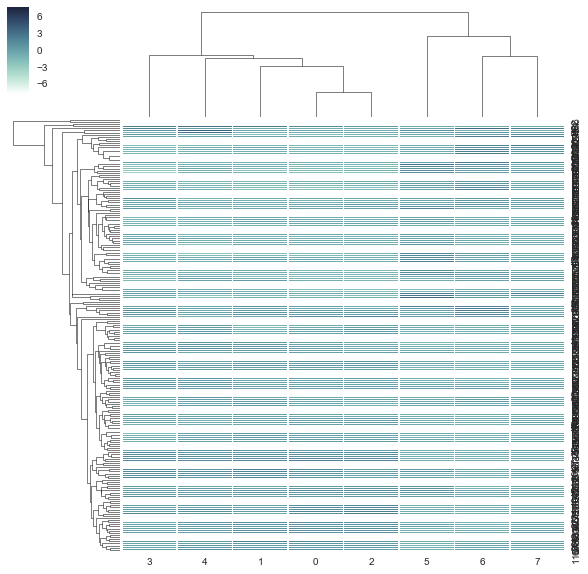

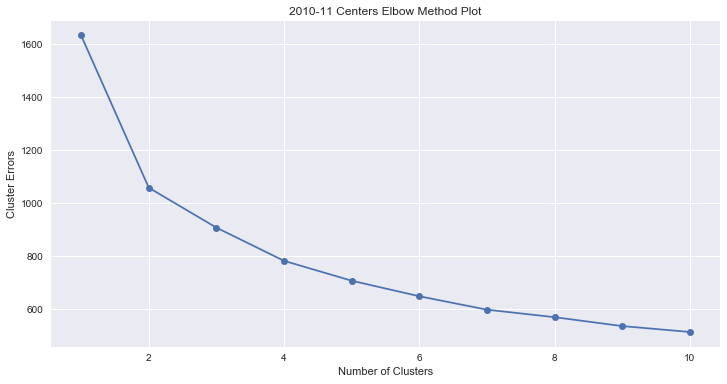

In [2410]:
plt.figure(figsize=(12,6))
plt.plot( clusters_dc.num_clusters, clusters_dc.cluster_errors, marker = "o" )
plt.title('2010-11 Centers Elbow Method Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Errors')
plt.show()
plt.savefig('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/centers_eblow_plot_2010-11.pdf')


### silhouette analysis

- The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
- The silhouette ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
- If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.
- The silhouette can be calculated with any distance metric, such as the Euclidean distance or the Manhattan distance.

Silhouette score of an observation is given by:
\begin{equation}
s(i)=\frac{b(i)−a(i)}{max[a(i),b(i)]}
\end{equation}

From the above definition it is clear that silhoutte score always lies between:

\begin{equation}
−1≤s(i)≤1−1≤s(i)≤1
\end{equation}
Score closer to 1 means assigned to the cluster correctly and score closer to -1 is assigned to a wrong cluster. A score close to 0 means the point lies between almost at the boundary of both the clusters.

For n_clusters = 2 The average silhouette_score is : 0.313334726235


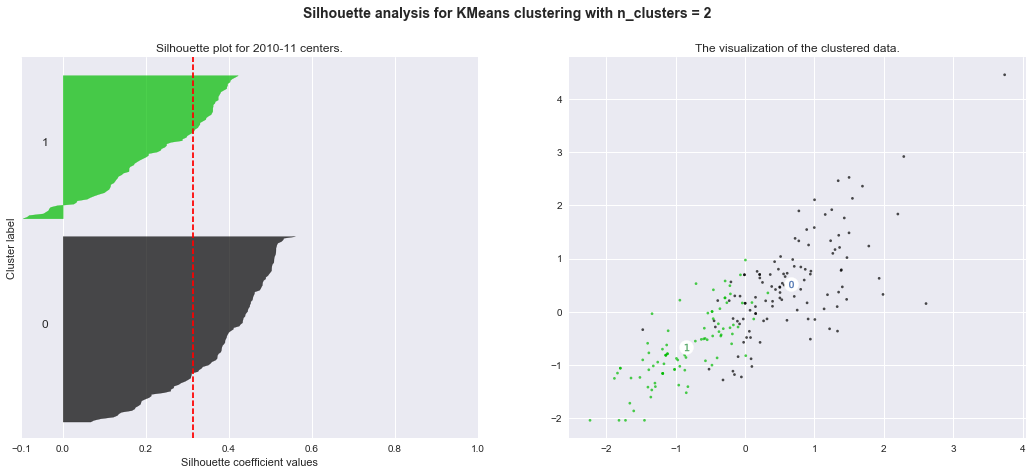

For n_clusters = 3 The average silhouette_score is : 0.204566304559


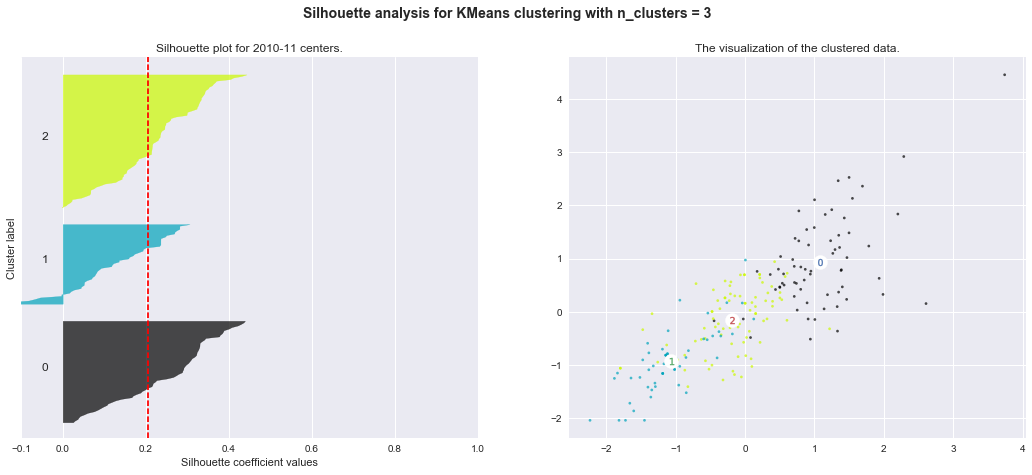

For n_clusters = 4 The average silhouette_score is : 0.21180062861


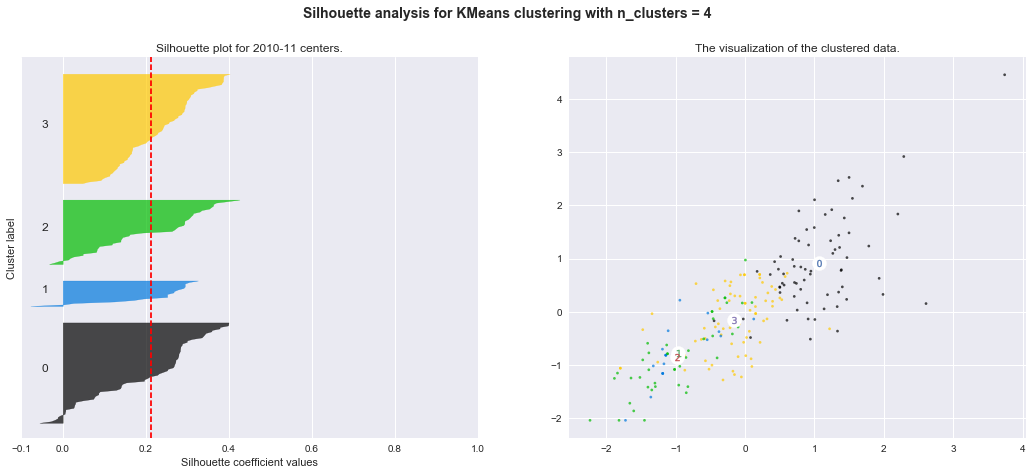

For n_clusters = 5 The average silhouette_score is : 0.212124237934


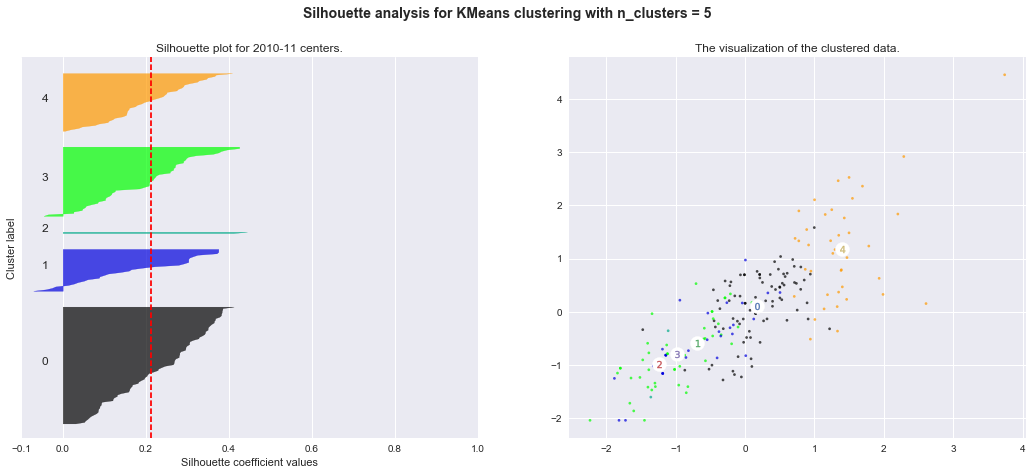

For n_clusters = 6 The average silhouette_score is : 0.179105654885


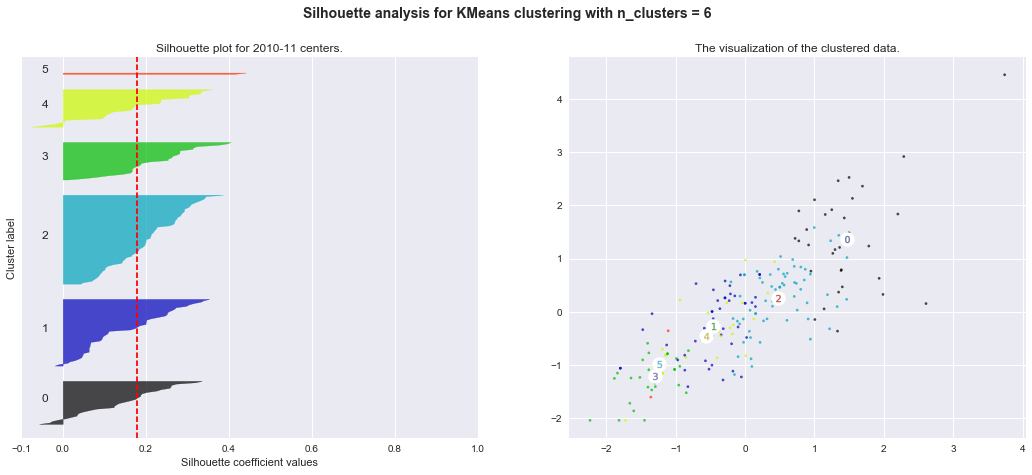

For n_clusters = 7 The average silhouette_score is : 0.179767510785


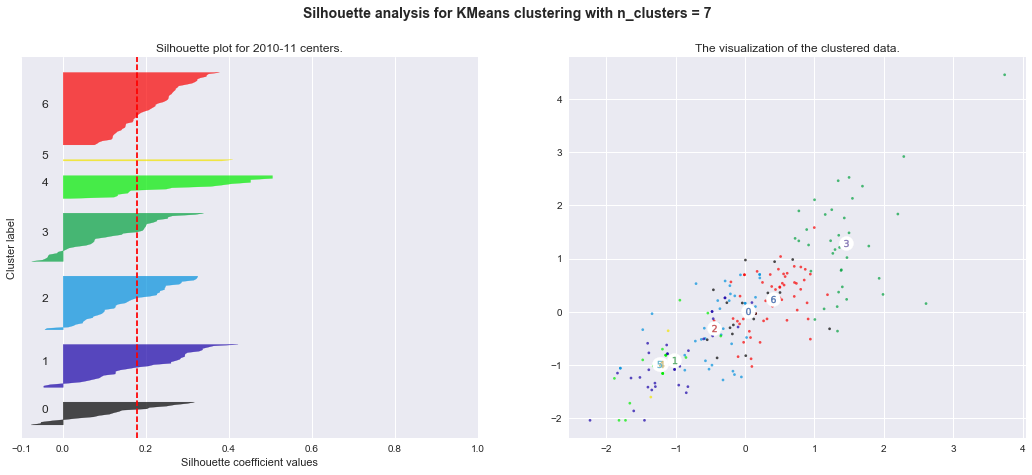

For n_clusters = 8 The average silhouette_score is : 0.177427269256


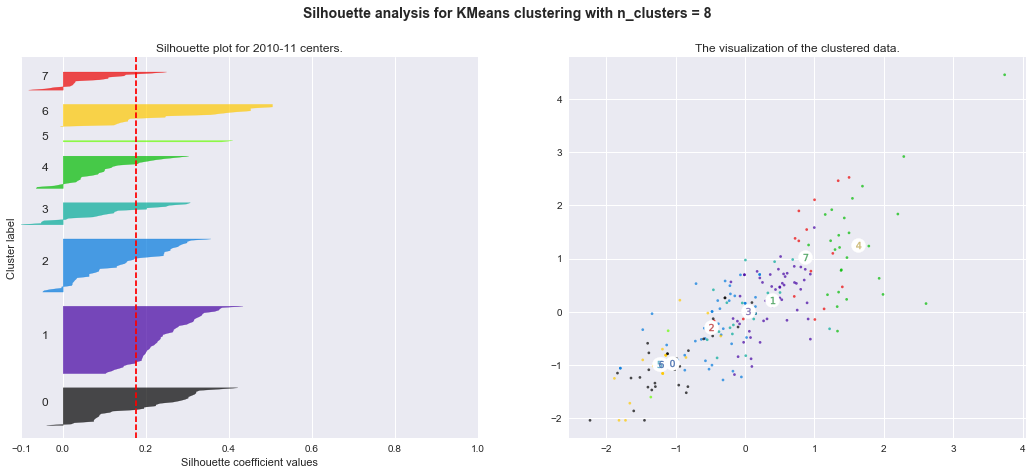

For n_clusters = 9 The average silhouette_score is : 0.179029653895


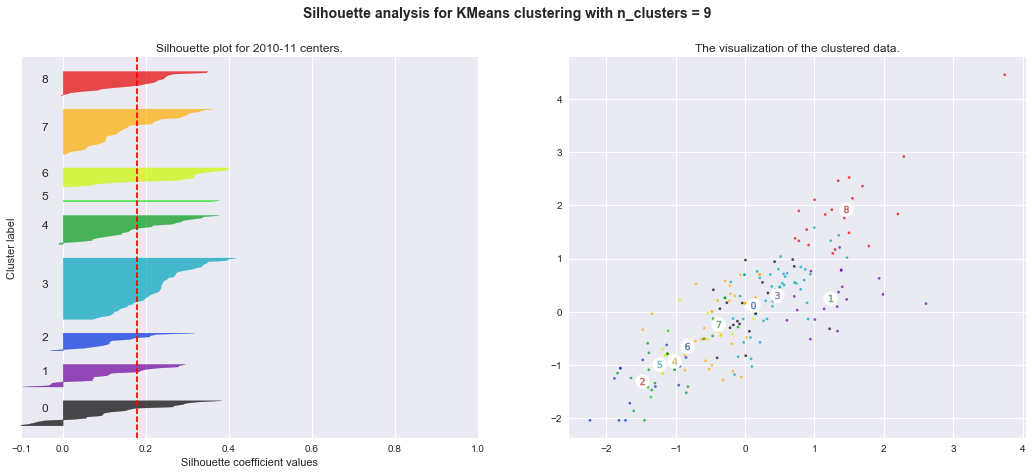

For n_clusters = 10 The average silhouette_score is : 0.170818426477


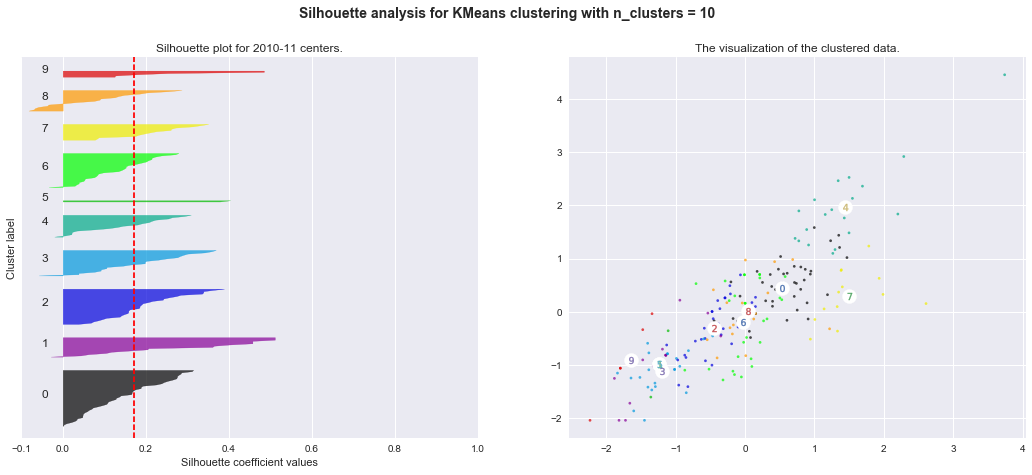

In [2403]:
cluster_range = range( 2, 11 )

for n_clusters in cluster_range:
  # Create a subplot with 1 row and 2 columns
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all
  # lie within [-0.1, 1]
  ax1.set_xlim([-0.1, 1])
  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax1.set_ylim([0, len(c_scaled) + (n_clusters + 1) * 10])

  # Initialize the clusterer with n_clusters value and a random generator
  # seed of 10 for reproducibility.
  clusterer = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=10)
  cluster_labels = clusterer.fit_predict( c_scaled )

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(c_scaled, cluster_labels)
  print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

  # Compute the silhouette scores for each sample
  sample_silhouette_values = silhouette_samples(c_scaled, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = \
          sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.spectral(float(i) / n_clusters)
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

  ax1.set_title("Silhouette plot for 2010-11 centers.")
  ax1.set_xlabel("Silhouette coefficient values")
  ax1.set_ylabel("Cluster label")

  # The vertical line for average silhoutte score of all the values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  # 2nd Plot showing the actual clusters formed
  colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
  ax2.scatter(c_scaled[:, 0], c_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7,
              c=colors)

  # Labeling the clusters
  centers = clusterer.cluster_centers_
  # Draw white circles at cluster centers
  ax2.scatter(centers[:, 0], centers[:, 1],
              marker='o', c="white", alpha=1, s=200)

  for i, c in enumerate(centers):
      ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

  ax2.set_title("The visualization of the clustered data.")
 

  plt.suptitle(("Silhouette analysis for KMeans clustering "
                "with n_clusters = %d" % n_clusters),
               fontsize=14, fontweight='bold')

  plt.show()
plt.savefig('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/centers_silhouette_analysis_2010-11.pdf')

In [2375]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(c_scaled)

clusters_dc = pd.DataFrame(kmeans.cluster_centers_,
                       columns=['TOIPoints', 'TOIGoals', 'TOIAssists', 'TOIPlus/Minus', 'TOIShotsD', 'TOIBlocks', 'TOIHits', 'TOIPenalties'])

dc['cluster']=kmeans.labels_

clusters_dc

,TOIPoints,TOIGoals,TOIAssists,TOIPlus/Minus,TOIShotsD,TOIBlocks,TOIHits,TOIPenalties
0,-0.927871,-0.696814,-0.899518,-0.527086,-0.862007,0.162926,2.130638,2.450642
1,0.153730,0.103532,0.156797,0.039857,0.303921,-0.408714,-0.329108,-0.204357
2,1.366658,1.157364,1.239520,1.030783,1.000045,-0.447862,-0.550467,-0.308757
3,-0.967615,-0.804811,-0.887126,-0.663857,-0.948996,0.912409,0.278251,-0.187890


In [2401]:
beginningtex = """\\documentclass{report}
\\usepackage{booktabs}
\\begin{document}"""
endtex = "\end{document}"

f = open('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/centers_silhouette_method_2010-2011.tex', 'w')
f.write(beginningtex)
f.write(clusters_dc.to_latex())
f.write(endtex)
f.close()

### rank centers

The next step is to rank players based on clusters:

- **Cluster 2** is for **1st** line (Top 3). 
- **Cluster 1** is for **2nd** second line (Top 6). 
- **Cluster 3** is for **3rd** third line (Top 9)
- **Cluster 0** is for **4th** fourth line (Bottom 3)

In [2376]:
dc['Rank'] = dc.apply(lambda x: 1 if (x['cluster'] == 2) else 2 if (x['cluster'] == 1) else 3 if (x['cluster'] == 3) else 4, axis=1)
dc = dc.sort_values(['TPoints'], ascending=[False])
dc['Rank'].value_counts()

2    88
3    57
1    42
4    17
Name: Rank, dtype: int64

In [2380]:
c = dc.copy()
c = c[['Rank', 'TeamCode', 'PlayerNumber', 'PlayerName', 'TGP', 'TPoints', 'TOIPoints', 'TOIGoals', 'TOIAssists' , 'TOIShotsF', 'TOIShotsA', 'TOIShotsD', 'TOIPlus/Minus', 'TOIGoalsF', 'TOIGoalsA', 'TOIBlocks', 'TOIHits', 'TTOI', 'TATOI']]
c = c[c['Rank'] == 4]
c = c.sort_values(['TPoints', 'TOIPoints'], ascending=[False, False])
c.head(10)

,Rank,TeamCode,PlayerNumber,PlayerName,TGP,TPoints,TOIPoints,TOIGoals,TOIAssists,TOIShotsF,TOIShotsA,TOIShotsD,TOIPlus/Minus,TOIGoalsF,TOIGoalsA,TOIBlocks,TOIHits,TTOI,TATOI
155,4,DAL,29,OTT,82.0,32.0,0.023163,0.008686,0.014477,0.444438,0.524784,-0.080346,-0.004343,0.025334,0.029677,0.031849,0.182408,1381.52,16.85
433,4,WSH,26,HENDRICKS,77.0,25.0,0.029001,0.010440,0.018561,0.460541,0.482582,-0.022041,-0.002320,0.033642,0.035962,0.044082,0.196049,862.03,11.20
443,4,BUF,8,MCCORMICK,80.0,20.0,0.022841,0.009136,0.013704,0.495643,0.460240,0.035403,0.002284,0.034261,0.031977,0.068522,0.123340,875.63,10.95
489,4,PIT,17,RUPP,81.0,17.0,0.020872,0.011050,0.009822,0.472694,0.439544,0.033150,-0.002456,0.027011,0.029467,0.020872,0.222228,814.48,10.06
410,4,ANA,14,LAPIERRE,77.0,12.0,0.013422,0.006711,0.006711,0.430620,0.548062,-0.117442,-0.014540,0.023488,0.020133,0.025725,0.216988,894.06,11.61
407,4,MTL,40,LAPIERRE,77.0,12.0,0.013422,0.006711,0.006711,0.430620,0.548062,-0.117442,-0.014540,0.023488,0.020133,0.025725,0.216988,894.06,11.61
414,4,VAN,40,LAPIERRE,77.0,12.0,0.013422,0.006711,0.006711,0.430620,0.548062,-0.117442,-0.014540,0.023488,0.020133,0.025725,0.216988,894.06,11.61
296,4,EDM,67,BRULE,41.0,9.0,0.015916,0.012379,0.003537,0.443871,0.516375,-0.072505,-0.012379,0.026526,0.038905,0.028295,0.167999,565.48,13.79
350,4,OTT,15,SMITH,54.0,9.0,0.013096,0.005820,0.007275,0.455438,0.497636,-0.042197,-0.014551,0.020371,0.034922,0.039287,0.187705,687.25,12.73
477,4,NYI,28,KONOPKA,82.0,9.0,0.010771,0.002394,0.008378,0.321936,0.630707,-0.308771,-0.019149,0.022739,0.041888,0.062233,0.131647,835.57,10.19


## clusters for wingers

In [2251]:
dw = dfs.copy()
dw = dw[dw['Position'] == 'W']
dw.shape

(279, 41)

### standardization

- It is important to standardize the data so that we can effectively compare player performance. 
- Scale on-ice events per minute for each player relative to the league's season minimum and maximumn performance. All on-ice events per minute will have values between 0 and 1. 
- This technique makes sure that no particular event is being overweighted.

In [2264]:
#scaler = MinMaxScaler()
scaler = StandardScaler()
w = dw[['TOIPoints', 'TOIGoals', 'TOIAssists', 'TOIPlus/Minus', 'TOIShotsD', 'TOIBlocks', 'TOIHits', 'TOIPenalties']]
w_scaled = scaler.fit_transform(w)

### dendrogram

- Dendogram shows the distance between any two observations in a dataset. The vertical axis determines the distance. The longer the axis, the larger the distance.
- The clustermap feature in seaborn provides the dendogram. It also displays the distance between observations as well as the features.

In [2265]:
cmap = sn.cubehelix_palette(as_cmap=True, rot=-.3, light=1)

In [2266]:
sn.clustermap(w_scaled, cmap=cmap, linewidths=.5)

/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


### elbow analysis

- Elbow method is a method of interpretation and validation of consistency within cluster analysis designed to help finding the appropriate number of clusters in a dataset.
- Explained Variance: This method looks at the percentage of variance explained as a function of the number of clusters: One should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data.
- if one plots the percentage of variance explained by the clusters against the number of clusters the first clusters will add much information (explain a lot of variance), but at some point the marginal gain in explained variance will drop, giving an angle in the graph. The number of clusters is chosen at this point, hence the "elbow criterion".

In [2388]:
cluster_range = range( 1, 11 )
cluster_errors = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( w_scaled )
  cluster_errors.append( clusters.inertia_ )

In [2389]:
clusters_dw = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_dw[0:10]

,cluster_errors,num_clusters
0,2232.000000,1
1,1442.909960,2
2,1220.092200,3
3,1053.829017,4
4,975.117179,5
5,904.302962,6
6,849.149640,7
7,812.224449,8
8,788.777697,9
9,747.718923,10


In [2391]:
beginningtex = """\\documentclass{report}
\\usepackage{booktabs}
\\begin{document}"""
endtex = "\end{document}"

f = open('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/wingers_elbow_method_2010-2011.tex', 'w')
f.write(beginningtex)
f.write(clusters_dw.to_latex())
f.write(endtex)
f.close()

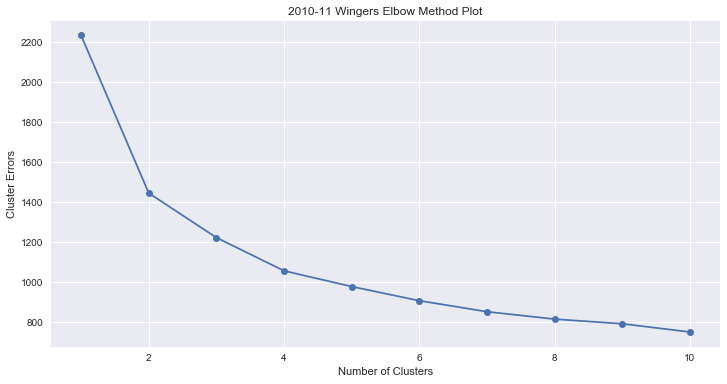

In [2390]:
plt.figure(figsize=(12,6))
plt.plot( clusters_dw.num_clusters, clusters_dw.cluster_errors, marker = "o" )
plt.title('2010-11 Wingers Elbow Method Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Errors')
plt.show()
plt.savefig('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/forwards_eblow_plot_2010-11.pdf')

### silhouette analysis

- The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
- The silhouette ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
- If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.
- The silhouette can be calculated with any distance metric, such as the Euclidean distance or the Manhattan distance.

Silhouette score of an observation is given by:
\begin{equation}
s(i)=\frac{b(i)−a(i)}{max[a(i),b(i)]}
\end{equation}

From the above definition it is clear that silhoutte score always lies between:

\begin{equation}
−1≤s(i)≤1−1≤s(i)≤1
\end{equation}
Score closer to 1 means assigned to the cluster correctly and score closer to -1 is assigned to a wrong cluster. A score close to 0 means the point lies between almost at the boundary of both the clusters.

For n_clusters = 2 The average silhouette_score is : 0.325930710473


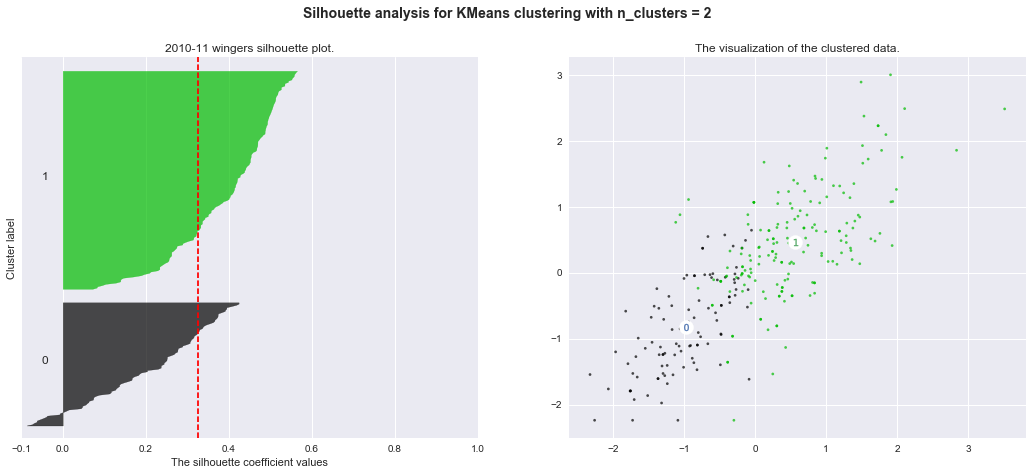

For n_clusters = 3 The average silhouette_score is : 0.270141001907


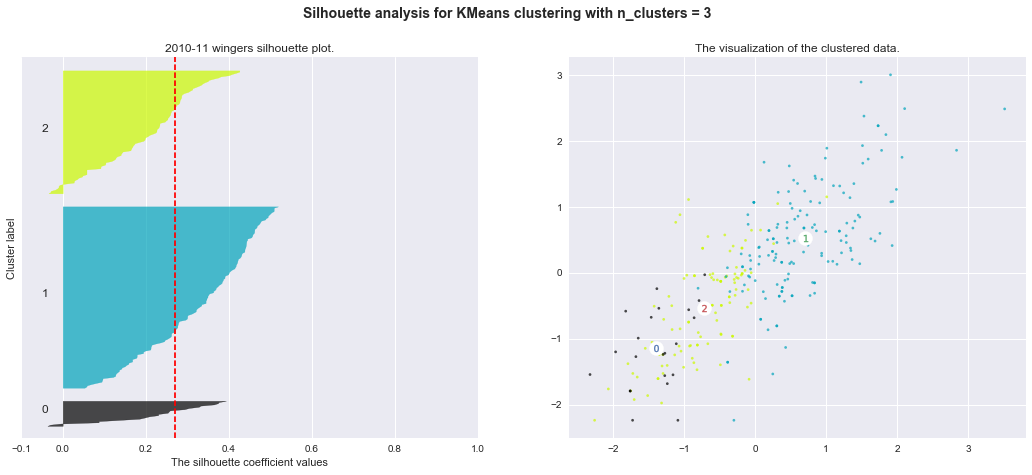

For n_clusters = 4 The average silhouette_score is : 0.199774975113


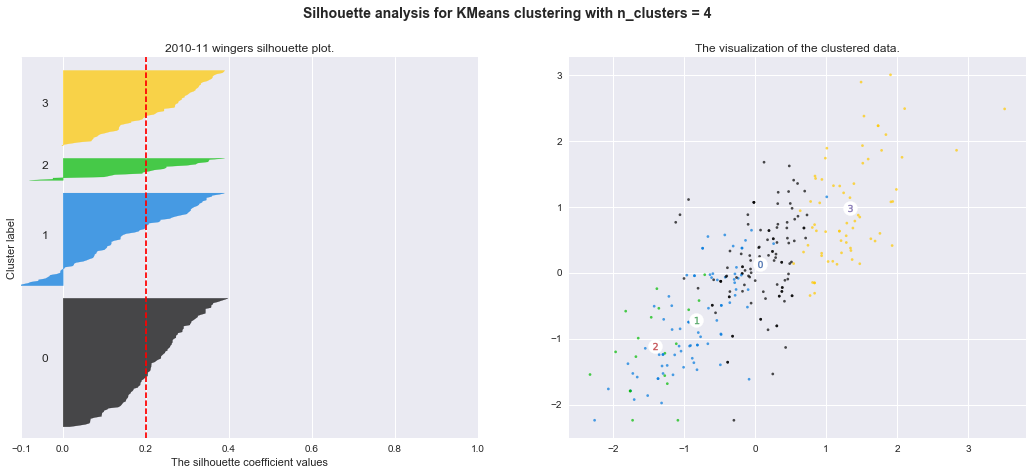

For n_clusters = 5 The average silhouette_score is : 0.170411901232


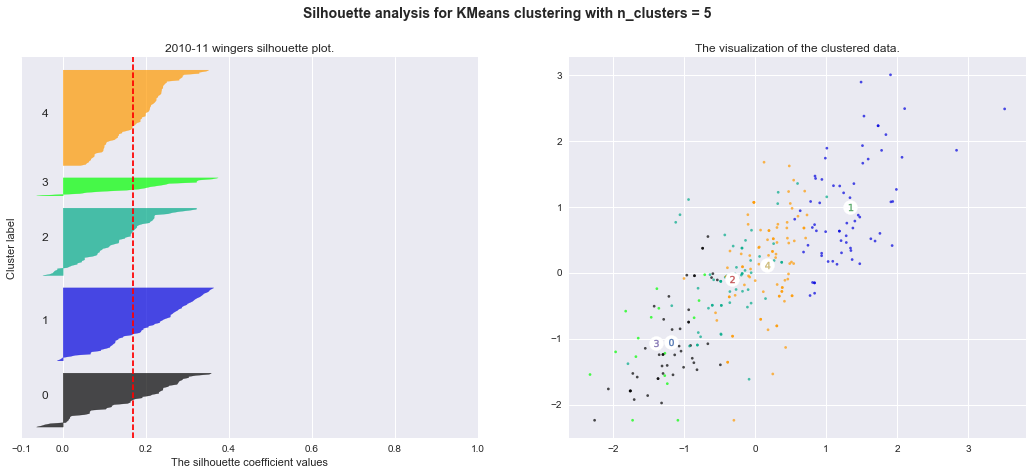

For n_clusters = 6 The average silhouette_score is : 0.174108502431


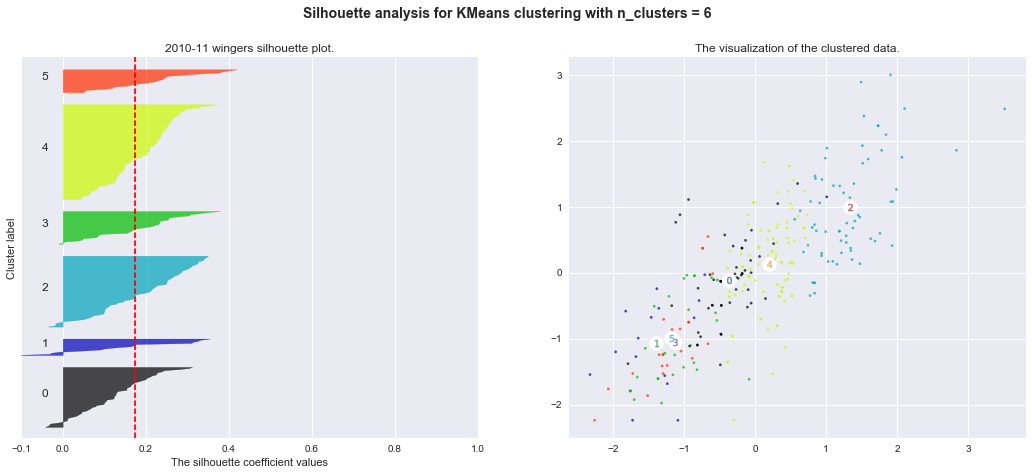

For n_clusters = 7 The average silhouette_score is : 0.173067814041


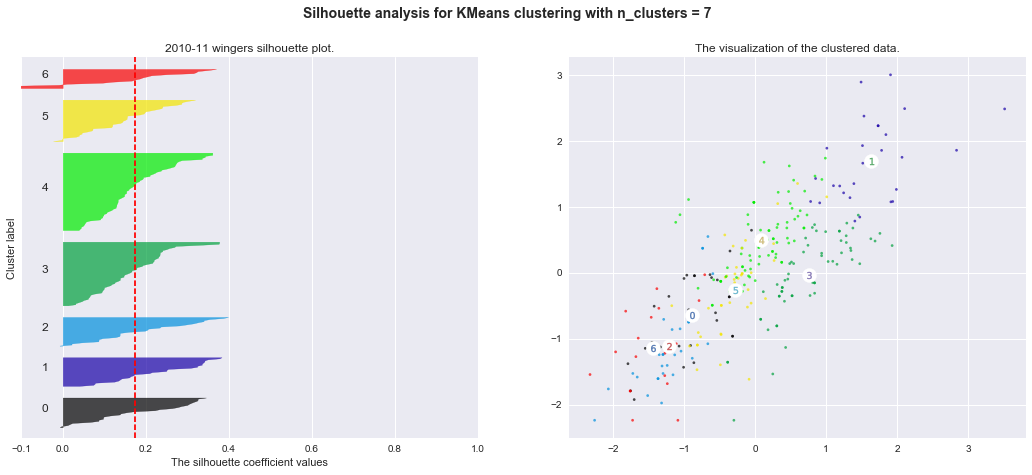

For n_clusters = 8 The average silhouette_score is : 0.161749565587


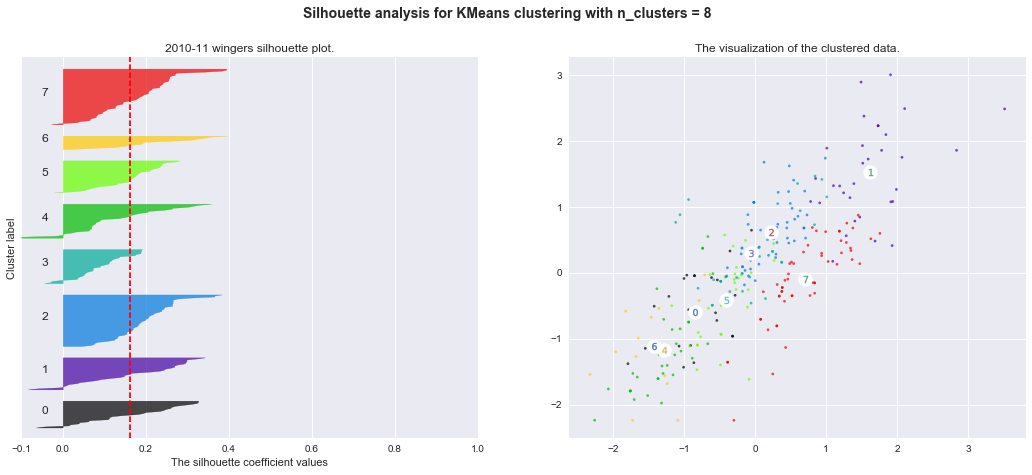

For n_clusters = 9 The average silhouette_score is : 0.157595600579


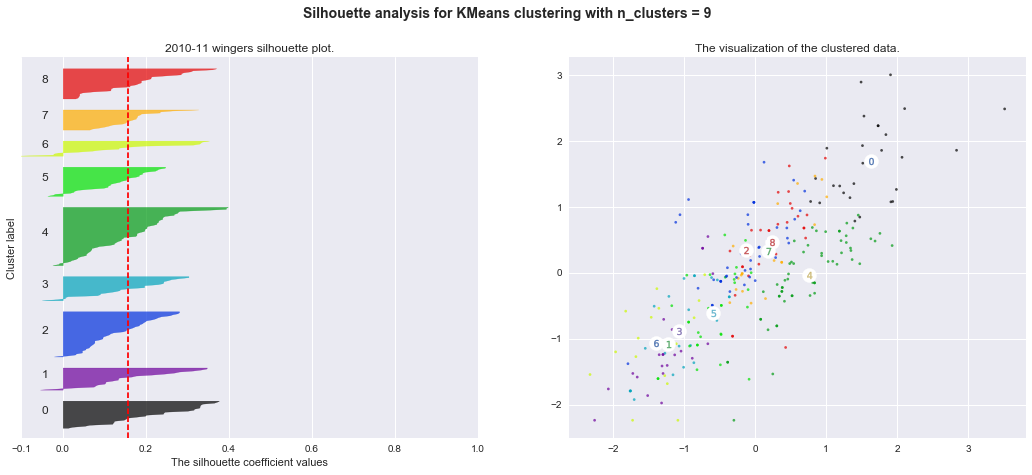

For n_clusters = 10 The average silhouette_score is : 0.157577597209


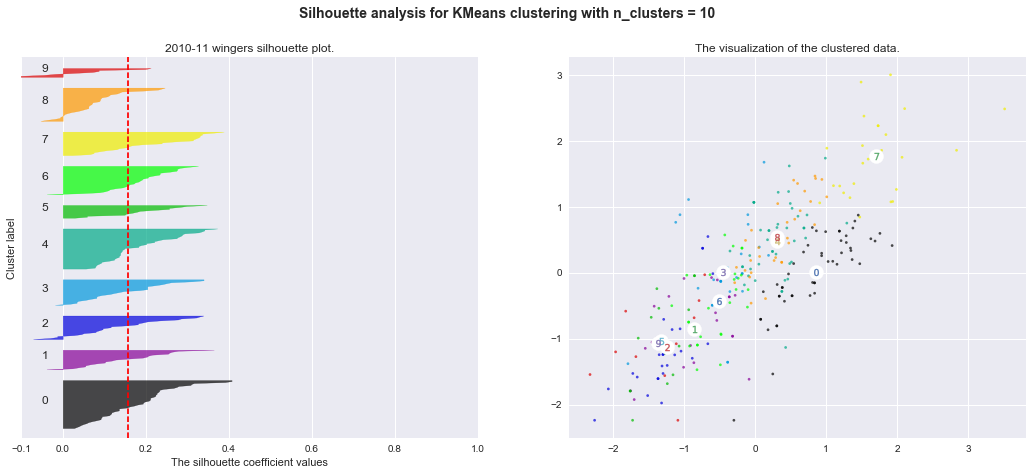

In [2393]:
cluster_range = range( 2, 11 )

for n_clusters in cluster_range:
  # Create a subplot with 1 row and 2 columns
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all
  # lie within [-0.1, 1]
  ax1.set_xlim([-0.1, 1])
  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax1.set_ylim([0, len(w_scaled) + (n_clusters + 1) * 10])

  # Initialize the clusterer with n_clusters value and a random generator
  # seed of 10 for reproducibility.
  clusterer = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=10)
  cluster_labels = clusterer.fit_predict( w_scaled )

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(w_scaled, cluster_labels)
  print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

  # Compute the silhouette scores for each sample
  sample_silhouette_values = silhouette_samples(w_scaled, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = \
          sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.spectral(float(i) / n_clusters)
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

  ax1.set_title("2010-11 wingers silhouette plot.")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")

  # The vertical line for average silhoutte score of all the values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  # 2nd Plot showing the actual clusters formed
  colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
  ax2.scatter(w_scaled[:, 0], w_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7,
              c=colors)

  # Labeling the clusters
  centers = clusterer.cluster_centers_
  # Draw white circles at cluster centers
  ax2.scatter(centers[:, 0], centers[:, 1],
              marker='o', c="white", alpha=1, s=200)

  for i, c in enumerate(centers):
      ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

  ax2.set_title("The visualization of the clustered data.")
 

  plt.suptitle(("Silhouette analysis for KMeans clustering "
                "with n_clusters = %d" % n_clusters),
               fontsize=14, fontweight='bold')

  plt.show()
plt.savefig('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/wingers_silhouette_analysis_2010-11.pdf')


Silhouette analysis for KMeans clustering show that the number of clusters with the highest values of the eleven statistics used, are n = 2, 3, 4 with an average silhouette score of 0.294, 0.200, 0.196 respectfully.
<br>
This indicates that the most natural cluster size were within this range. From a hockey perspective, since there are 4 forward lines, the optimal number of clusters for centers, left and right wingers are 4. 

- Top Line
- Second Line
- Third Line
- Fourth Line

In [2398]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(w_scaled)

clusters_dw = pd.DataFrame(kmeans.cluster_centers_,
                       columns=['TOIPoints', 'TOIGoals', 'TOIAssists', 'TOIPlus/Minus', 'TOIShotsD', 'TOIBlocks', 'TOIHits', 'TOIPenalties'])

dw['cluster']=kmeans.labels_

clusters_dw

,TOIPoints,TOIGoals,TOIAssists,TOIPlus/Minus,TOIShotsD,TOIBlocks,TOIHits,TOIPenalties
0,-0.824967,-0.715164,-0.669990,-0.456544,-1.018428,0.775179,0.322833,0.000599
1,-1.349279,-1.051335,-1.187958,-1.039050,-0.827160,0.506731,2.145107,2.640774
2,1.330442,0.981090,1.214639,0.808173,0.796247,-0.522702,-0.513640,-0.340407
3,0.072286,0.138819,-0.000589,0.060283,0.408201,-0.333500,-0.378932,-0.365695


In [2399]:
beginningtex = """\\documentclass{report}
\\usepackage{booktabs}
\\begin{document}"""
endtex = "\end{document}"

f = open('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/wingers_silhouette_method_2010-2011.tex', 'w')
f.write(beginningtex)
f.write(clusters_dw.to_latex())
f.write(endtex)
f.close()

The table shows the 4 clusters broken out into the variables we input into the model. Cluster 1 is the cluster of top-performing forwards. Remember, these numbers are scaled, so the number points per time on ice (MPoints) cluster 1 forwards is 0.55 standard deviations above the mean for all forwards.

In [791]:
#clusters_dw.to_csv('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/clusters_wingers.csv')
#clusters_dw.to_csv('/Users/kevinmongeon/Brock University/Steve Tselios - StephanosShare/out/clusters/clusters_wingers.csv')

### rank wingers

The next step is to rank players based on clusters:

- **Cluster 1** is for **1st** line (Top 3). 
- **Cluster 3** is for **2nd** second line (Top 6). 
- **Cluster 0** is for **3rd** third line (Top 9)
- **Cluster 2** is for **4th** fourth line (Bottom 3)

In [2400]:
dw['Rank'] = dw.apply(lambda x: 1 if (x['cluster'] == 2) else 2 if (x['cluster'] == 3) else 3 if (x['cluster'] == 0) else 4, axis=1)
dw = dw.sort_values(['TPoints'], ascending=[False])
dw['Rank'].value_counts()

2    112
3     77
1     66
4     24
Name: Rank, dtype: int64

In [2250]:
w2 = dw.copy()
w2 = w2[['Rank', 'TeamCode', 'PlayerNumber', 'PlayerName', 'TGP', 'TPoints', 'TOIPoints', 'TOIGoals', 'TOIAssists' , 'TOIShotsF', 'TOIShotsA', 'TOIShotsD', 'TOIPlus/Minus', 'TOIGoalsF', 'TOIGoalsA', 'TOIBlocks', 'TOIHits', 'TTOI', 'TATOI']]
w2 = w2[w2['Rank'] == 2]
w2 = w2.sort_values(['TPoints', 'TOIPoints'], ascending=[False, False])
w2.head()


,Rank,TeamCode,PlayerNumber,PlayerName,TGP,TPoints,TOIPoints,TOIGoals,TOIAssists,TOIShotsF,TOIShotsA,TOIShotsD,TOIPlus/Minus,TOIGoalsF,TOIGoalsA,TOIBlocks,TOIHits,TTOI,TATOI
1,2,NJ,17,KOVALCHUK,81.0,60.0,0.033270,0.017189,0.016080,0.540082,0.409775,0.130307,-0.011090,0.028279,0.039369,0.006654,0.015526,1803.43,22.26
22,2,ATL,16,LADD,81.0,59.0,0.036401,0.017892,0.018509,0.606479,0.515785,0.090694,-0.003085,0.035167,0.038252,0.027764,0.041954,1620.83,20.01
44,2,LA,23,BROWN,82.0,57.0,0.035891,0.017631,0.018261,0.543410,0.426920,0.116490,0.011964,0.038410,0.026446,0.018261,0.188903,1588.12,19.37
58,2,DAL,10,MORROW,82.0,56.0,0.035730,0.021055,0.014675,0.555088,0.452365,0.102723,0.001914,0.040196,0.038282,0.027435,0.143557,1567.32,19.11
59,2,NYI,26,MOULSON,81.0,54.0,0.034938,0.020057,0.014881,0.608833,0.466492,0.142341,-0.005823,0.034938,0.040761,0.031056,0.054349,1545.58,19.08


## total stats defensemen

- create a data frame for defensemen (LD, RD) and exclude faceoff per time on ice (MFaceoffs) variable. Follow the same process as above (forwards).

In [2426]:
ddf = dws.copy()
ddf = dws[dws['Position'] == 'D']
ddf = ddf.sort_values(['GP', 'TOI'], ascending=[True, True])
ddf.head()

,Season,TeamCode,PlayerNumber,PlayerName,Position,GP,Goals,Assists,Points,GoalsF,GoalsA,Plus/Minus,Shots,ShotsF,ShotsA,DShots,Blocks,Hits,Penalties,Takeaways,Giveaways,Misses,Faceoffs,GameNumber,Period,StartTime,EndTime,Shift,Seconds,Minutes,TSeconds,TOI,ATOI
671,2010,NSH,32,LAAKSO,D,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,20106,2,244.0,281.0,37.0,163.0,2.72,163.0,2.72,2.72
1049,2010,NYI,29,DOORNBOSCH,D,1,0,0,0,0,1,-1,1,3,7,-4,0,1,0,2,0,0,0,21205,2,358.0,378.0,20.0,321.0,5.35,321.0,5.35,5.35
1054,2010,NYI,55,SIMS,D,1,0,0,0,0,0,0,0,3,5,-2,0,1,0,1,0,0,0,21218,1,307.0,360.0,53.0,394.0,6.57,394.0,6.57,6.57
1047,2010,NYI,55,CAMPANALE,D,1,0,0,0,0,0,0,0,2,9,-7,0,0,2,0,0,0,0,21193,3,124.0,144.0,20.0,501.0,8.35,501.0,8.35,8.35
1014,2010,ATL,38,POSTMA,D,1,0,0,0,0,0,0,1,6,5,1,2,1,0,0,0,0,0,21002,1,10.0,45.0,35.0,595.0,9.92,595.0,9.92,9.92


In [2427]:
ddf.shape

(342, 33)

- defensemen that have been traded need to be evaluated for their season performance.

In [2428]:
d= ddf.copy()
d['Count'] = d.apply(lambda x: 1 if (x['PlayerName'] == x['PlayerName']) else 0, axis=1)
d['Player'] = d.groupby('PlayerName')['Count'].transform('sum')
d = d[d['Player'] > 1]

In [2429]:
d.shape

(85, 35)

- exclude defensemen that have the same name but are different individuals.

In [2430]:
d = d[(d['PlayerName'] !='WEBER') & (d['PlayerName'] !='SCHULTZ') & (d['PlayerName'] !='WILSON') & (d['PlayerName'] !='GREENE') & (d['PlayerName'] !='MOORE')]
d.shape

(74, 35)

- season stats for traded defensemen.

In [2431]:
# total games played for the season
d['TGP'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['GP'], axis=1)
d['TGP'] = d.groupby('PlayerName')['TGP'].transform('sum')
d['TGP'] = d.apply(lambda x: x['GP'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['GP'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['GP'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TGP'], axis=1)

# total points for the season
d['TPoints'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['Points'], axis=1)
d['TPoints'] = d.groupby('PlayerName')['TPoints'].transform('sum')
d['TPoints'] = d.apply(lambda x: x['Points'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['Points'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['Points'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TPoints'], axis=1)

# total goals for the season
d['TGoals'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['Goals'], axis=1)
d['TGoals'] = d.groupby('PlayerName')['TGoals'].transform('sum')
d['TGoals'] = d.apply(lambda x: x['Goals'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['Goals'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['Goals'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TGoals'], axis=1)

# total assists for the season
d['TAssists'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['Assists'], axis=1)
d['TAssists'] = d.groupby('PlayerName')['TAssists'].transform('sum')
d['TAssists'] = d.apply(lambda x: x['Assists'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['Assists'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['Assists'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TAssists'], axis=1)

# total goals for on-ice for the season
d['TGoalsF'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['GoalsF'], axis=1)
d['TGoalsF'] = d.groupby('PlayerName')['TGoalsF'].transform('sum')
d['TGoalsF'] = d.apply(lambda x: x['GoalsF'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['GoalsF'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['GoalsF'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TGoalsF'], axis=1)

# total goals against on-ice for the season
d['TGoalsA'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['GoalsA'], axis=1)
d['TGoalsA'] = d.groupby('PlayerName')['TGoalsA'].transform('sum')
d['TGoalsA'] = d.apply(lambda x: x['GoalsA'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['GoalsA'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['GoalsA'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TGoalsA'], axis=1)

# total shots against on-ice for the season
d['TPlus/Minus'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['Plus/Minus'], axis=1)
d['TPlus/Minus'] = d.groupby('PlayerName')['TPlus/Minus'].transform('sum')
d['TPlus/Minus'] = d.apply(lambda x: x['Plus/Minus'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['Plus/Minus'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['Plus/Minus'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TPlus/Minus'], axis=1)

# total shots against on-ice for the season
d['TShots'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['Shots'], axis=1)
d['TShots'] = d.groupby('PlayerName')['TShots'].transform('sum')
d['TShots'] = d.apply(lambda x: x['Shots'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['Shots'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['Shots'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TShots'], axis=1)

# total shots for on-ice for the season
d['TShotsF'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['ShotsF'], axis=1)
d['TShotsF'] = d.groupby('PlayerName')['TShotsF'].transform('sum')
d['TShotsF'] = d.apply(lambda x: x['ShotsA'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['ShotsA'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['ShotsA'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TShotsF'], axis=1)

# total shots against on-ice for the season
d['TShotsA'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['ShotsA'], axis=1)
d['TShotsA'] = d.groupby('PlayerName')['TShotsA'].transform('sum')
d['TShotsA'] = d.apply(lambda x: x['ShotsA'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['ShotsA'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['ShotsA'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TShotsA'], axis=1)

# total shot differential on-ice for the season
d['TShotsD'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['DShots'], axis=1)
d['TShotsD'] = d.groupby('PlayerName')['TShotsD'].transform('sum')
d['TShotsD'] = d.apply(lambda x: x['ShotsA'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['ShotsA'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['ShotsA'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TShotsD'], axis=1)

# total blocks for the season
d['TBlocks'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['Blocks'], axis=1)
d['TBlocks'] = d.groupby('PlayerName')['TBlocks'].transform('sum')
d['TBlocks'] = d.apply(lambda x: x['Blocks'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['Blocks'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['Blocks'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TBlocks'], axis=1)

# total hits for the season
d['THits'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['Hits'], axis=1)
d['THits'] = d.groupby('PlayerName')['THits'].transform('sum')
d['THits'] = d.apply(lambda x: x['Hits'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['Hits'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['Hits'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['THits'], axis=1)

# total misses for the season
d['TMisses'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['Misses'], axis=1)
d['TMisses'] = d.groupby('PlayerName')['TMisses'].transform('sum')
d['TMisses'] = d.apply(lambda x: x['Misses'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['Misses'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['Misses'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TMisses'], axis=1)

# total penalties for the season
d['TPenalties'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['Penalties'], axis=1)
d['TPenalties'] = d.groupby('PlayerName')['TPenalties'].transform('sum')
d['TPenalties'] = d.apply(lambda x: x['Penalties'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['Penalties'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['Penalties'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TPenalties'], axis=1)

# total giveaways for the season
d['TGiveaways'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['Giveaways'], axis=1)
d['TGiveaways'] = d.groupby('PlayerName')['TGiveaways'].transform('sum')
d['TGiveaways'] = d.apply(lambda x: x['Giveaways'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['Giveaways'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['Giveaways'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TGiveaways'], axis=1)

# total takeaways for the season
d['TTakeaways'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['Takeaways'], axis=1)
d['TTakeaways'] = d.groupby('PlayerName')['TTakeaways'].transform('sum')
d['TTakeaways'] = d.apply(lambda x: x['Takeaways'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['Takeaways'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['Takeaways'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TTakeaways'], axis=1)

# time on ice for the season
d['TTOI'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TOI'], axis=1)
d['TTOI'] = d.groupby('PlayerName')['TTOI'].transform('sum')
d['TTOI'] = d.apply(lambda x: x['Points'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['TOI'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['TOI'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TTOI'], axis=1)

- merge traded players onto defensmen dataframe. Keep total season stats per player.

In [2432]:
dwd = pd.merge(ddf, d, on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Position', 'GP', 'Goals', 'Assists', 'Points', 'GoalsF', 'GoalsA', 'Plus/Minus', 'Shots', 'ShotsF', 'ShotsA', 'DShots', 'Blocks', 'Hits', 'Misses', 'Penalties', 'Giveaways', 'Takeaways', 'TOI', 'ATOI'], how='left')

- season stats per defensemen.

In [2433]:
dwd['TGP'] = dwd.apply(lambda x: x['GP'] if pd.isnull(x['TGP']) else x['TGP'], axis=1)

dwd['TPoints'] = dwd.apply(lambda x: x['Points'] if pd.isnull(x['TPoints']) else x['TPoints'], axis=1)
dwd['TGoals'] = dwd.apply(lambda x: x['Goals'] if pd.isnull(x['TGoals']) else x['TGoals'], axis=1)
dwd['TAssists'] = dwd.apply(lambda x: x['Assists'] if pd.isnull(x['TAssists']) else x['TAssists'], axis=1)

dwd['TGoalsF'] = dwd.apply(lambda x: x['GoalsF'] if pd.isnull(x['TGoalsF']) else x['TGoalsF'], axis=1)
dwd['TGoalsA'] = dwd.apply(lambda x: x['GoalsA'] if pd.isnull(x['TGoalsA']) else x['TGoalsA'], axis=1)
dwd['TPlus/Minus'] = dwd.apply(lambda x: x['Plus/Minus'] if pd.isnull(x['TPlus/Minus']) else x['TPlus/Minus'], axis=1)

dwd['TShots'] = dwd.apply(lambda x: x['Shots'] if pd.isnull(x['TShots']) else x['TShots'], axis=1)
dwd['TShotsF'] = dwd.apply(lambda x: x['ShotsF'] if pd.isnull(x['TShotsF']) else x['TShotsF'], axis=1)
dwd['TShotsA'] = dwd.apply(lambda x: x['ShotsA'] if pd.isnull(x['TShotsA']) else x['TShotsA'], axis=1)
dwd['TShotsD'] = dwd.apply(lambda x: x['DShots'] if pd.isnull(x['TShotsD']) else x['TShotsD'], axis=1)

dwd['TMisses'] = dwd.apply(lambda x: x['Misses'] if pd.isnull(x['TMisses']) else x['TMisses'], axis=1)
dwd['TBlocks'] = dwd.apply(lambda x: x['Blocks'] if pd.isnull(x['TBlocks']) else x['TBlocks'], axis=1)
dwd['THits'] = dwd.apply(lambda x: x['Hits'] if pd.isnull(x['THits']) else x['THits'], axis=1)
dwd['TPenalties'] = dwd.apply(lambda x: x['Penalties'] if pd.isnull(x['TPenalties']) else x['TPenalties'], axis=1)

dwd['TGiveaways'] = dwd.apply(lambda x: x['Giveaways'] if pd.isnull(x['TGiveaways']) else x['TGiveaways'], axis=1)
dwd['TTakeaways'] = dwd.apply(lambda x: x['Takeaways'] if pd.isnull(x['TTakeaways']) else x['TTakeaways'], axis=1)

dwd['TTOI'] = dwd.apply(lambda x: x['TOI'] if pd.isnull(x['TTOI']) else x['TTOI'], axis=1)


In [2434]:
dwd['TOIPoints'] = dwd['TPoints']/dwd['TTOI']
dwd['TOIGoals'] = dwd['TGoals']/dwd['TTOI']
dwd['TOIAssists'] = dwd['TAssists']/dwd['TTOI']

dwd['TOIGoalsF'] = dwd['TGoalsF']/dwd['TTOI']
dwd['TOIGoalsA'] = dwd['TGoalsA']/dwd['TTOI']
dwd['TOIPlus/Minus'] = dwd['TPlus/Minus']/dwd['TTOI']

dwd['TOIShots'] = dwd['TShots']/dwd['TTOI']
dwd['TOIShotsF'] = dwd['TShotsF']/dwd['TTOI']
dwd['TOIShotsA'] = dwd['TShotsA']/dwd['TTOI']
dwd['TOIShotsD'] = dwd['TShotsD']/dwd['TTOI']

dwd['TOIMisses'] = dwd['TMisses']/dwd['TTOI']
dwd['TOIBlocks'] = dwd['TBlocks']/dwd['TTOI']
dwd['TOIHits'] = dwd['THits']/dwd['TTOI']
dwd['TOIPenalties'] = dwd['TPenalties']/dwd['TTOI']

dwd['TOIGiveaways'] = dwd['TGiveaways']/dwd['TGP']
dwd['TOITakeaways'] = dwd['TTakeaways']/dwd['TTOI']

dwd['TATOI'] = dwd['TTOI']/dwd['TGP']

In [2435]:
dwd.columns

Index(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Position', 'GP',
       'Goals', 'Assists', 'Points', 'GoalsF', 'GoalsA', 'Plus/Minus', 'Shots',
       'ShotsF', 'ShotsA', 'DShots', 'Blocks', 'Hits', 'Penalties',
       'Takeaways', 'Giveaways', 'Misses', 'Faceoffs_x', 'GameNumber_x',
       'Period_x', 'StartTime_x', 'EndTime_x', 'Shift_x', 'Seconds_x',
       'Minutes_x', 'TSeconds_x', 'TOI', 'ATOI', 'Faceoffs_y', 'GameNumber_y',
       'Period_y', 'StartTime_y', 'EndTime_y', 'Shift_y', 'Seconds_y',
       'Minutes_y', 'TSeconds_y', 'Count', 'Player', 'TGP', 'TPoints',
       'TGoals', 'TAssists', 'TGoalsF', 'TGoalsA', 'TPlus/Minus', 'TShots',
       'TShotsF', 'TShotsA', 'TShotsD', 'TBlocks', 'THits', 'TMisses',
       'TPenalties', 'TGiveaways', 'TTakeaways', 'TTOI', 'TOIPoints',
       'TOIGoals', 'TOIAssists', 'TOIGoalsF', 'TOIGoalsA', 'TOIPlus/Minus',
       'TOIShots', 'TOIShotsF', 'TOIShotsA', 'TOIShotsD', 'TOIMisses',
       'TOIBlocks', 'TOIHits', 'TOIPenalties',

In [2436]:
dwd = dwd [['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Position', 'TGP', 'TPoints', 'TGoals', 'TAssists', 'TGoalsF', 'TGoalsA', 'TPlus/Minus', 'TShots', 'TShotsF', 'TShotsA', 'TShotsD', 'TBlocks', 'THits', 'TMisses', 'TPenalties', 'TGiveaways', 'TTakeaways', 'TTOI', 'TOIPoints', 'TOIGoals', 'TOIAssists', 'TOIGoalsF', 'TOIGoalsA', 'TOIPlus/Minus', 'TOIShots', 'TOIShotsF', 'TOIShotsA', 'TOIShotsD', 'TOIMisses', 'TOIBlocks', 'TOIHits', 'TOIPenalties', 'TOIGiveaways', 'TOITakeaways', 'TATOI' ]]

### defensemen time on ice distribution

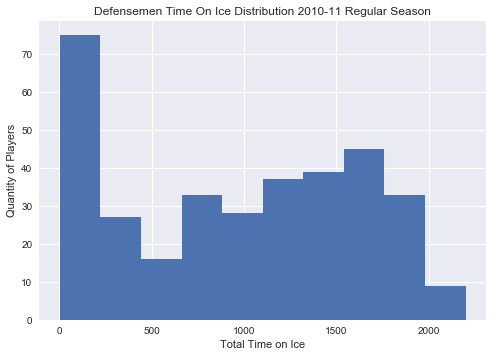

In [2451]:
x3 = dwd.TTOI 
plt.title('Defensemen Time On Ice Distribution 2010-11 Regular Season')
plt.xlabel('Total Time on Ice')
plt.ylabel('Quantity of Players')
#plt.xlim(222,223)
plt.hist(x3)
plt.show()
plt.savefig('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/defensemen_toi.pdf')

- Defensemen that have played less than 225 minutes for the season are excluded from the cluster analysis. Since game level data is being used, those players will be ranked as 3rd pairing defensemen.

In [2453]:
dwd = dwd[dwd['TTOI'] > 225]
dwd.shape

(267, 40)

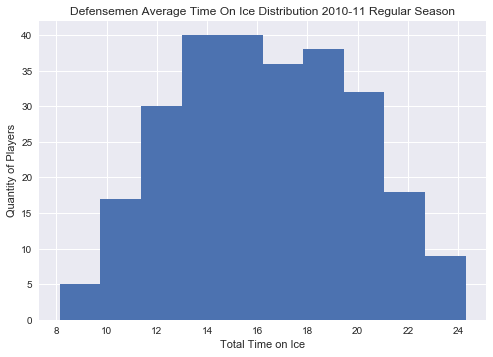

In [1635]:
x4 = dwd.TATOI 
plt.title('Defensemen Average Time On Ice Distribution 2010-11 Regular Season')
plt.xlabel('Total Time on Ice')
plt.ylabel('Quantity of Players')
#plt.xlim(197,220)
plt.hist(x4)
plt.show()

In [2454]:
dwd.to_csv('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/total_stats_defensemen_nhl_positions.csv', index='False', sep=',')
#dwd.to_csv('/Users/kevinmongeon/Brock University/Steve Tselios - StephanosShare/out/clusters/total_stats_defensemen_nhl_positions.csv', index='False', sep=',')

## clusters for defensemen

In [2455]:
dwd.head()

,Season,TeamCode,PlayerNumber,PlayerName,Position,TGP,TPoints,TGoals,TAssists,TGoalsF,TGoalsA,TPlus/Minus,TShots,TShotsF,TShotsA,TShotsD,TBlocks,THits,TMisses,TPenalties,TGiveaways,TTakeaways,TTOI,TOIPoints,TOIGoals,TOIAssists,TOIGoalsF,TOIGoalsA,TOIPlus/Minus,TOIShots,TOIShotsF,TOIShotsA,TOIShotsD,TOIMisses,TOIBlocks,TOIHits,TOIPenalties,TOIGiveaways,TOITakeaways,TATOI
28,2010,MTL,20,OBYRNE,D,67.0,0.0,0.0,0.0,38.0,47.0,-9.0,45.0,541.0,759.0,-218.0,131.0,179.0,29.0,73.0,25.0,21.0,1340.50,0.000000,0.000000,0.000000,0.028348,0.035062,-0.006714,0.033570,0.403581,0.566207,-0.162626,0.021634,0.097725,0.133532,0.054457,0.373134,0.015666,20.007463
32,2010,ANA,24,BEAUCHEMIN,D,81.0,17.0,5.0,12.0,61.0,70.0,-9.0,106.0,782.0,915.0,-133.0,182.0,122.0,56.0,32.0,90.0,34.0,1869.21,0.009095,0.002675,0.006420,0.032634,0.037449,-0.004815,0.056708,0.418359,0.489512,-0.071153,0.029959,0.097367,0.065268,0.017120,1.111111,0.018190,23.076667
50,2010,ANA,60,MIKKELSON,D,23.0,2.0,0.0,2.0,8.0,13.0,-5.0,14.0,137.0,205.0,-68.0,18.0,21.0,10.0,7.0,9.0,2.0,324.85,0.006157,0.000000,0.006157,0.024627,0.040018,-0.015392,0.043097,0.421733,0.631060,-0.209327,0.030783,0.055410,0.064645,0.021548,0.391304,0.006157,14.123913
67,2010,FLA,2,SULZER,D,39.0,5.0,1.0,4.0,16.0,23.0,-7.0,37.0,298.0,330.0,-32.0,52.0,38.0,19.0,14.0,10.0,8.0,684.60,0.007304,0.001461,0.005843,0.023371,0.033596,-0.010225,0.054046,0.435291,0.482033,-0.046743,0.027753,0.075957,0.055507,0.020450,0.256410,0.011686,17.553846
68,2010,PHI,24,BOYNTON,D,51.0,8.0,1.0,7.0,32.0,33.0,-1.0,43.0,352.0,366.0,-14.0,87.0,61.0,16.0,38.0,25.0,15.0,746.98,0.010710,0.001339,0.009371,0.042839,0.044178,-0.001339,0.057565,0.471231,0.489973,-0.018742,0.021420,0.116469,0.081662,0.050872,0.490196,0.020081,14.646667


In [2570]:
#scaler = MinMaxScaler()
scaler = StandardScaler()
d = dwd[['TOIPoints', 'TOIGoals', 'TOIAssists', 'TOIPlus/Minus', 'TOIShotsD', 'TOIBlocks', 'TOIHits', 'TOIPenalties']]
d_scaled = scaler.fit_transform(d)

### dendrogram

In [2571]:
cmap = sn.cubehelix_palette(as_cmap=True, rot=-.3, light=1)

In [2572]:
sn.clustermap(d_scaled, cmap=cmap, linewidths=.5)

/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


### elbow analysis

In [2573]:
cluster_range = range( 1, 11 )
cluster_errors = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( d_scaled )
  cluster_errors.append( clusters.inertia_ )

In [2574]:
clusters_dwd = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_dwd[0:10]

,cluster_errors,num_clusters
0,2136.000000,1
1,1467.605649,2
2,1284.806987,3
3,1151.151304,4
4,1052.419405,5
5,977.487312,6
6,930.019478,7
7,886.296004,8
8,834.428747,9
9,812.122291,10


In [2575]:
beginningtex = """\\documentclass{report}
\\usepackage{booktabs}
\\begin{document}"""
endtex = "\end{document}"

f = open('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/defensemen_elbow_method_2010-2011.tex', 'w')
f.write(beginningtex)
f.write(clusters_dwd.to_latex())
f.write(endtex)
f.close()

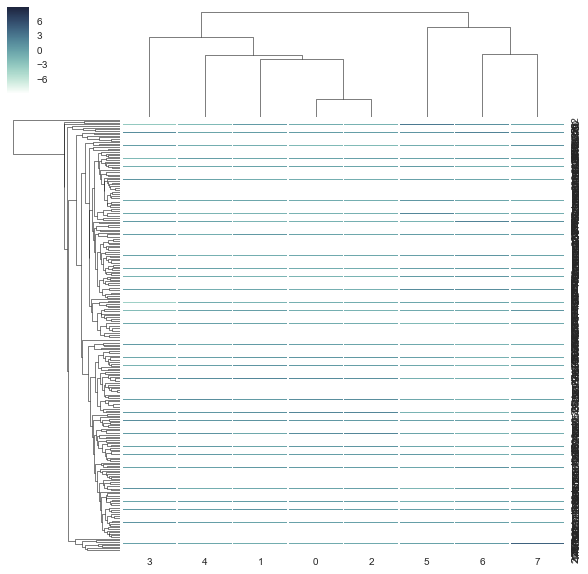

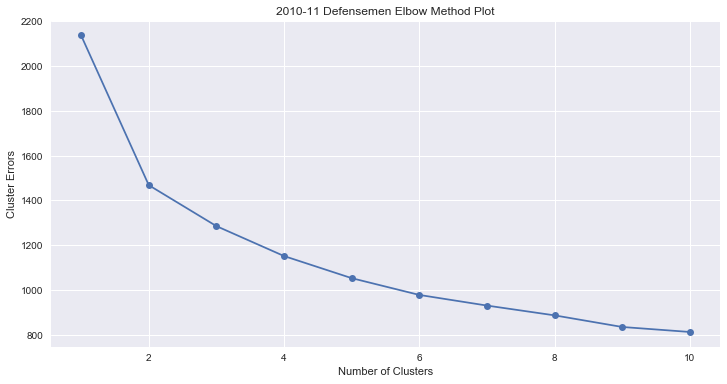

In [2576]:
plt.figure(figsize=(12,6))
plt.plot( clusters_dwd.num_clusters, clusters_dwd.cluster_errors, marker = "o" )
plt.title('2010-11 Defensemen Elbow Method Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Errors')
plt.show()
plt.savefig('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/defensemen_eblow_plot_2010-11.pdf')

### silhouette analysis

For n_clusters = 2 The average silhouette_score is : 0.274517166729


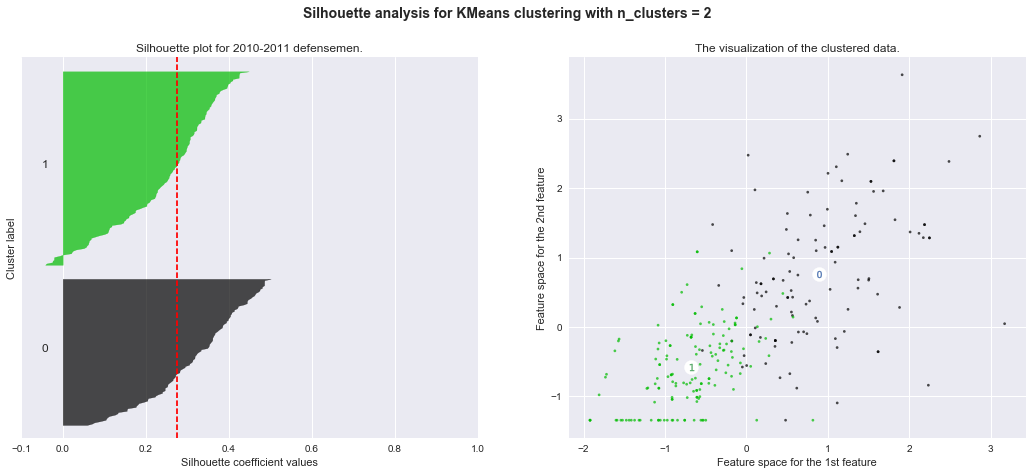

For n_clusters = 3 The average silhouette_score is : 0.206443929042


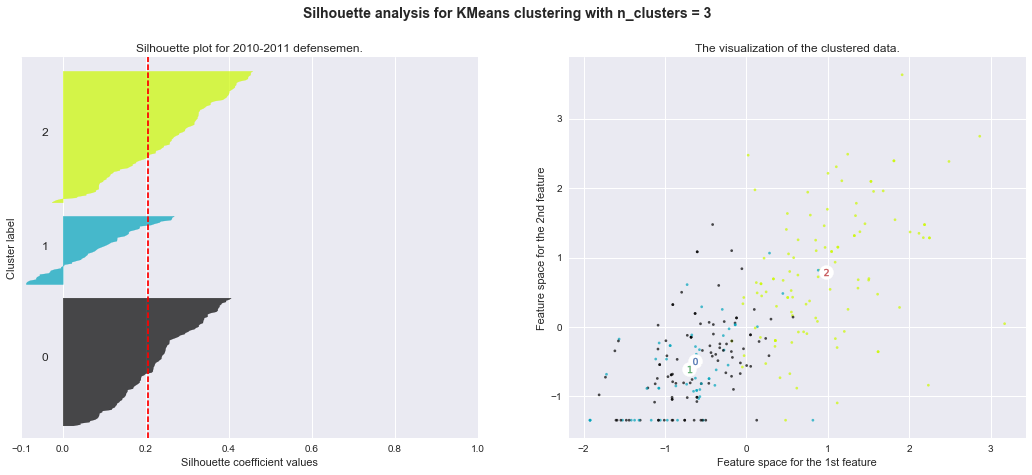

For n_clusters = 4 The average silhouette_score is : 0.168622711146


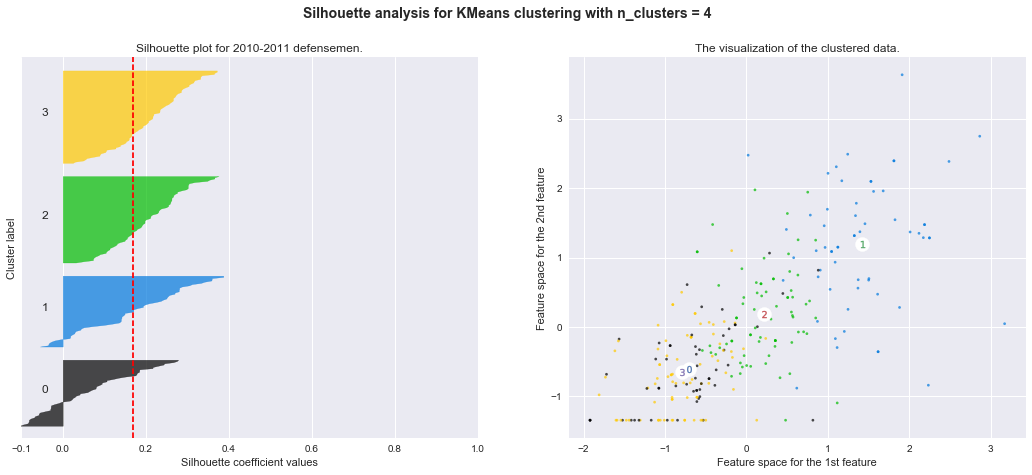

For n_clusters = 5 The average silhouette_score is : 0.159388738425


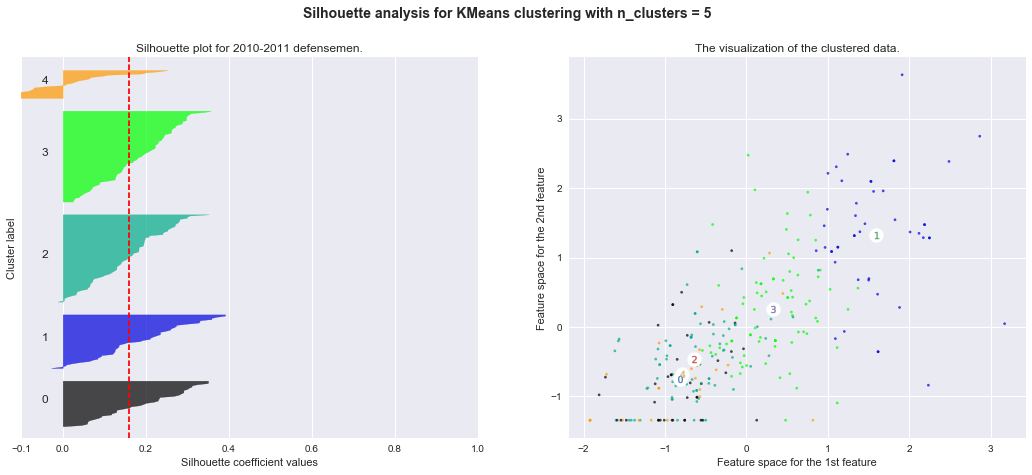

For n_clusters = 6 The average silhouette_score is : 0.162600807537


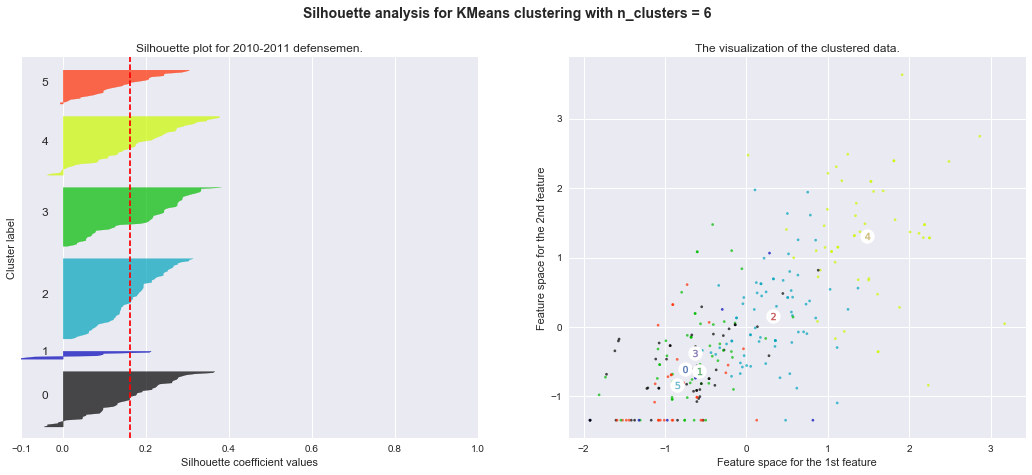

For n_clusters = 7 The average silhouette_score is : 0.161267974968


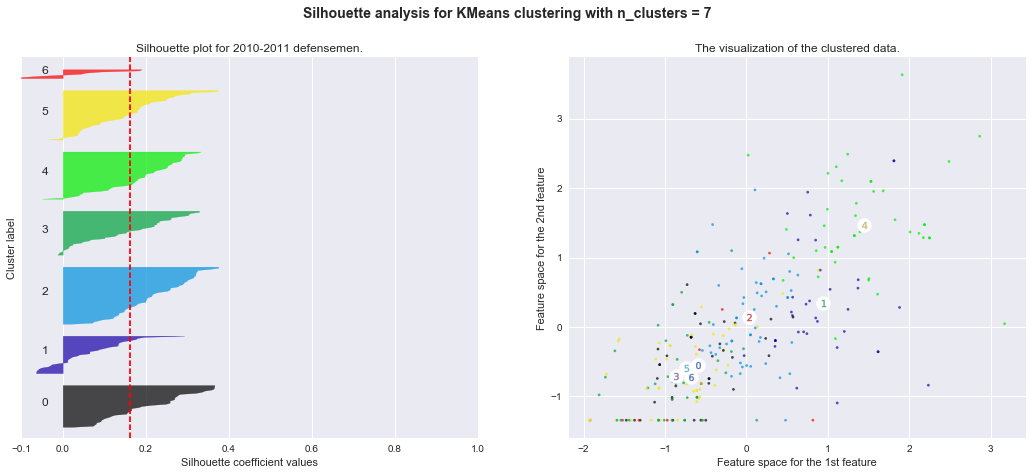

For n_clusters = 8 The average silhouette_score is : 0.160350791792


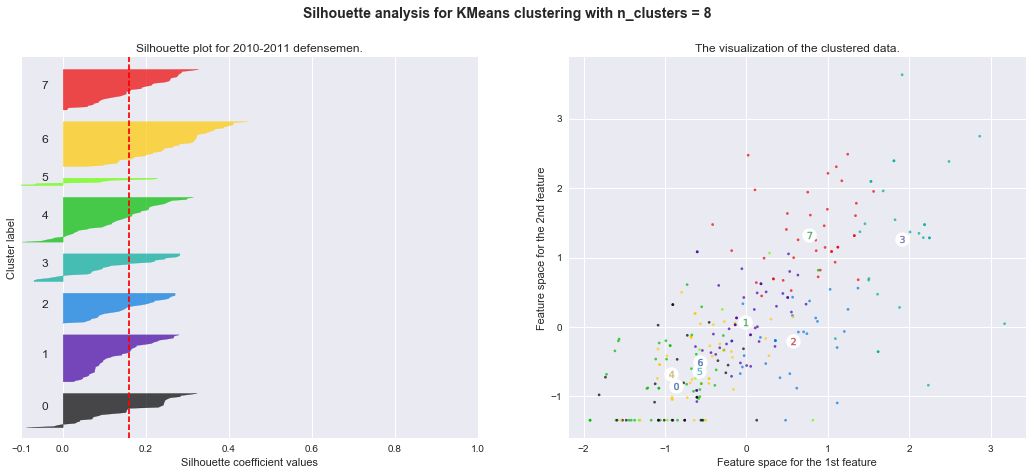

For n_clusters = 9 The average silhouette_score is : 0.162821675124


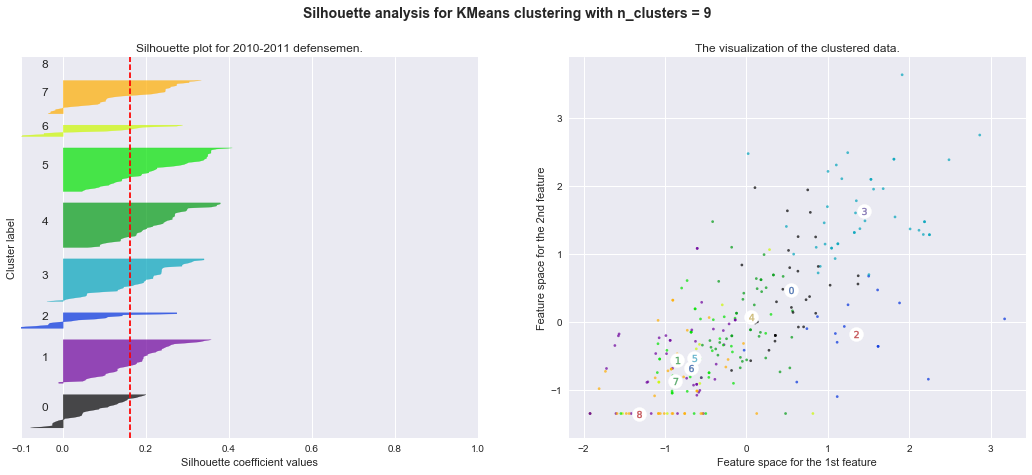

For n_clusters = 10 The average silhouette_score is : 0.148257837985


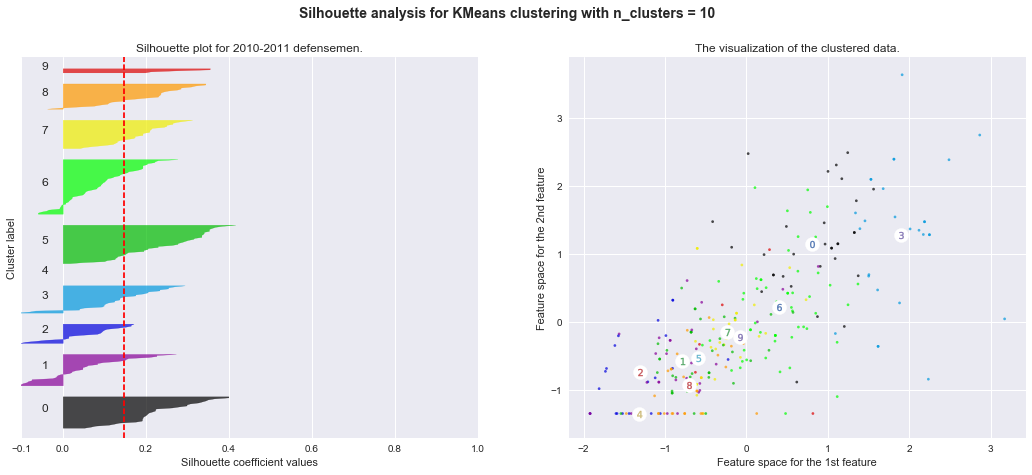

In [2577]:
cluster_range = range( 2, 11 )

for n_clusters in cluster_range:
  # Create a subplot with 1 row and 2 columns
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all
  # lie within [-0.1, 1]
  ax1.set_xlim([-0.1, 1])
  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax1.set_ylim([0, len(d_scaled) + (n_clusters + 1) * 10])

  # Initialize the clusterer with n_clusters value and a random generator
  # seed of 10 for reproducibility.
  clusterer = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=10)
  cluster_labels = clusterer.fit_predict( d_scaled )

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(d_scaled, cluster_labels)
  print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

  # Compute the silhouette scores for each sample
  sample_silhouette_values = silhouette_samples(d_scaled, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = \
          sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.spectral(float(i) / n_clusters)
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

  ax1.set_title("Silhouette plot for 2010-2011 defensemen.")
  ax1.set_xlabel("Silhouette coefficient values")
  ax1.set_ylabel("Cluster label")

  # The vertical line for average silhoutte score of all the values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  # 2nd Plot showing the actual clusters formed
  colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
  ax2.scatter(d_scaled[:, 0], d_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7,
              c=colors)

  # Labeling the clusters
  centers = clusterer.cluster_centers_
  # Draw white circles at cluster centers
  ax2.scatter(centers[:, 0], centers[:, 1],
              marker='o', c="white", alpha=1, s=200)

  for i, c in enumerate(centers):
      ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

  ax2.set_title("The visualization of the clustered data.")
  ax2.set_xlabel("Feature space for the 1st feature")
  ax2.set_ylabel("Feature space for the 2nd feature")

  plt.suptitle(("Silhouette analysis for KMeans clustering "
                "with n_clusters = %d" % n_clusters),
               fontsize=14, fontweight='bold')

  plt.show()
plt.savefig('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/defensemen_silhouette_analysis_2010-11.pdf')


Silhouette analysis for KMeans clustering of defensemen shows that the number of clusters with the highest values of the eleven statistics used, are $n$ = 2, 3, 4. These clusters have an average silhouette score of 0.249, 0.173 and 0.141 respectfully. 
This indicates that the most natural cluster size were within this range. From a hockey perspective, since there are 3 defensive pairings, the optimal number of clusters for left and right defensemen are 3. 
- Top Two Defensive Pairing (LD, RD)
- Top Four Defensive Pairing (LD, RD)
- Bottom Defensive Pairing (LD, RD)


In [2579]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(d_scaled)

clusters_dwd = pd.DataFrame(kmeans.cluster_centers_,
                       columns=['TOIPoints', 'TOIGoals', 'TOIAssists', 'TOIPlus/Minus', 'TOIShotsD', 'TOIBlocks', 'TOIHits', 'TOIPenalties'])

dwd['cluster']=kmeans.labels_

clusters_dwd

,TOIPoints,TOIGoals,TOIAssists,TOIPlus/Minus,TOIShotsD,TOIBlocks,TOIHits,TOIPenalties
0,-0.594669,-0.478637,-0.554036,-0.244622,-0.399880,0.093505,-0.231252,-0.270027
1,1.011848,0.817194,0.941661,0.404809,0.862214,-0.367402,-0.472999,-0.293915
2,-0.725936,-0.589903,-0.674216,-0.275550,-0.855326,0.534829,1.467654,1.191889


In [2581]:
beginningtex = """\\documentclass{report}
\\usepackage{booktabs}
\\begin{document}"""
endtex = "\end{document}"

f = open('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/defensemen_silhouette_method_2010-2011.tex', 'w')
f.write(beginningtex)
f.write(clusters_dwd.to_latex())
f.write(endtex)
f.close()

In [2477]:
#clusters_dwd.to_csv('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/clusters_defensemen.csv')
#clusters_dwd.to_csv('/Users/kevinmongeon/Brock University/Steve Tselios - StephanosShare/out/clusters/clusters_defensemen.csv')

The table shows the 3 clusters broken out into the variables we input into the model. Cluster 1 is the cluster of top-performing defensemen. Remember, these numbers are scaled, so the number points per time on ice (MPoints) cluster 1 defesemen is 0.59 standard deviations above the mean for all defensemen.

### rank defensemen

The next step is to rank players based on clusters:

- **Cluster 1** is for **1st** pairing defensemen (Top 2). 
- **Cluster 0** is for **2nd** pairing defensemen (Top 4). 
- **Cluster 2** is for **3rd** pairing defensemen (Bottom 2)

display the number of players per rank

In [2580]:
dwd['Rank'] = dwd.apply(lambda x: 1 if (x['cluster'] == 1) else 2 if (x['cluster'] == 0) else 3, axis=1)
dwd = dwd.sort_values(['TPoints'], ascending=[False])
dwd['Rank'].value_counts()

2    113
1    103
3     51
Name: Rank, dtype: int64

In [2582]:
d2 = dwd.copy()
d2 = d2[['Rank', 'TeamCode', 'PlayerNumber', 'PlayerName', 'TGP', 'TPoints', 'TOIPoints', 'TOIHits', 'TOIBlocks', 'TTOI', 'TATOI']]
d2 = d2[d2['Rank'] == 2]
d2 = d2.sort_values(['TPoints', 'TOIPoints'], ascending=[False, False])
d2.head()

,Rank,TeamCode,PlayerNumber,PlayerName,TGP,TPoints,TOIPoints,TOIHits,TOIBlocks,TTOI,TATOI
315,2,BOS,44,SEIDENBERG,81.0,32.0,0.016777,0.084411,0.091227,1907.33,23.547284
303,2,NYR,5,GIRARDI,79.0,31.0,0.016102,0.101287,0.122583,1925.22,24.369873
317,2,DAL,3,ROBIDAS,81.0,30.0,0.015212,0.109525,0.068453,1972.15,24.347531
290,2,NYR,18,STAAL,77.0,29.0,0.014781,0.071359,0.055558,1961.92,25.479481
313,2,DAL,6,DALEY,81.0,27.0,0.014963,0.017733,0.068717,1804.50,22.277778


## combine forward and defenseman dataframes

In [2583]:
dataframes = [dc, dw, dwd]
#dataframes = [dww, dwd]
dr = pd.concat(dataframes)
dr = dr.sort_values(['Position', 'Rank'], ascending=[True, True])
dr.head()

,PlayerName,PlayerNumber,Position,Rank,Season,TATOI,TAssists,TBlocks,TGP,TGiveaways,TGoals,TGoalsA,TGoalsF,THits,TMisses,TOIAssists,TOIBlocks,TOIFaceoffs,TOIGiveaways,TOIGoals,TOIGoalsA,TOIGoalsF,TOIHits,TOIMisses,TOIPenalties,TOIPlus/Minus,TOIPoints,TOIShots,TOIShotsA,TOIShotsD,TOIShotsF,TOITakeaways,TPenalties,TPlus/Minus,TPoints,TShots,TShotsA,TShotsD,TShotsF,TTOI,TTakeaways,TeamCode,cluster
50,SEDIN,33,C,1,2010,19.26,75.0,21.0,82.0,38.0,19.0,49.0,77.0,15.0,42.0,0.047490,0.013297,0.456537,0.463415,0.012031,0.031027,0.048756,0.009498,0.026594,0.025328,0.017730,0.059521,0.099412,0.411580,0.257712,0.669292,0.027228,40.0,28.0,94.0,157.0,650.0,407.0,1057.0,1579.28,43.0,VAN,2
18,STAMKOS,91,C,1,2010,20.19,47.0,37.0,82.0,60.0,45.0,55.0,71.0,84.0,133.0,0.028393,0.022352,0.260373,0.731707,0.027185,0.033226,0.042892,0.050745,0.080347,0.044704,0.009666,0.055578,0.164319,0.441002,0.182442,0.623444,0.024165,74.0,16.0,92.0,272.0,730.0,302.0,1032.0,1655.32,40.0,TB,2
5,RICHARDS,91,C,1,2010,21.66,49.0,22.0,72.0,73.0,28.0,45.0,58.0,20.0,122.0,0.031427,0.014110,0.321325,1.013889,0.017958,0.028862,0.037199,0.012827,0.078247,0.015393,0.008338,0.049385,0.174452,0.464350,0.116087,0.580437,0.030144,24.0,13.0,77.0,272.0,724.0,181.0,905.0,1559.17,47.0,DAL,2
2,STAAL,12,C,1,2010,22.01,43.0,31.0,81.0,44.0,33.0,74.0,68.0,81.0,133.0,0.024114,0.017385,0.470510,0.543210,0.018506,0.041499,0.038134,0.045425,0.074586,0.040378,-0.003365,0.042621,0.165997,0.527712,0.066174,0.593886,0.035891,72.0,-6.0,76.0,296.0,941.0,118.0,1059.0,1783.17,64.0,CAR,2
4,GETZLAF,15,C,1,2010,21.86,57.0,57.0,67.0,81.0,19.0,54.0,71.0,189.0,65.0,0.038925,0.038925,0.370130,1.208955,0.012975,0.036876,0.048486,0.129068,0.044388,0.023901,0.011609,0.051900,0.079899,0.444566,0.127019,0.571585,0.023901,35.0,17.0,76.0,117.0,651.0,186.0,837.0,1464.35,35.0,ANA,2


In [2584]:
dr['Rank'].value_counts()

2    313
1    211
3    185
4     41
Name: Rank, dtype: int64

In [2585]:
dr.shape

(750, 43)

- create and save new dataframe that contains season, team code, player number, player name, position and rank columns.

In [2588]:
drs = dr[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Position', 'Rank']]

In [2589]:
drs.shape

(750, 6)

In [2590]:
drs.to_csv('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/player_rank_nhl_positions.csv')
#dr.to_csv('/Users/kevinmongeon/Brock University/Steve Tselios - StephanosShare/out/clusters/player_rank_nhl_positions.csv')